<a href="https://colab.research.google.com/github/kmeng01/rome/blob/main/notebooks/causal_trace.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" align="left"/></a>&nbsp;or in a local notebook.

In [1]:
IS_COLAB = False

## Causal Tracing

A demonstration of the double-intervention causal tracing method.

The strategy used by causal tracing is to understand important
states within a transfomer by doing two interventions simultaneously:

1. Corrupt a subset of the input.  In our paper, we corrupt the subject tokens
   to frustrate the ability of the transformer to accurately complete factual
   prompts about the subject.
2. Restore a subset of the internal hidden states.  In our paper, we scan
   hidden states at all layers and all tokens, searching for individual states
   that carry the necessary information for the transformer to recover its
   capability to complete the factual prompt.

The traces of decisive states can be shown on a heatmap.  This notebook
demonstrates the code for conducting causal traces and creating these heatmaps.

In [2]:
%load_ext autoreload
%autoreload 2

The `experiments.causal_trace` module contains a set of functions for running causal traces.

In this notebook, we reproduce, demonstrate and discuss the interesting functions.

We begin by importing several utility functions that deal with tokens and transformer models.

In [3]:
import os, sys, re, json
import string
import torch
import numpy as np
import copy
from collections import defaultdict, Counter
from util import nethook
from util.globals import DATA_DIR
from experiments.causal_trace import (
    ModelAndTokenizer,
    layername,
    guess_subject,
    plot_trace_heatmap,
)
from experiments.causal_trace import (
    make_inputs,
    decode_tokens,
    find_token_range,
    predict_token,
    predict_from_input,
    collect_embedding_std,
)
from dsets import KnownsDataset

In [4]:
torch.set_grad_enabled(False)

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

## USKG

In [6]:
from transformers import (
    HfArgumentParser,
    set_seed,
    AutoTokenizer
)

# from uskg.models.unified.prefixtuning import Model
from uskg.models.unified import finetune, prefixtuning
from uskg.utils.configue import Configure
from uskg.utils.training_arguments import WrappedSeq2SeqTrainingArguments
from uskg.seq2seq_construction import spider as s2s_spider
from uskg.third_party.spider.preprocess.get_tables import dump_db_json_schema
from uskg.third_party.spider import evaluation as sp_eval
from tqdm.notebook import tqdm

# from nltk.stem.wordnet import WordNetLemmatizer
# import stanza

import matplotlib.pyplot as plt
import sqlite3

from experiments import causal_trace_uskg as ctu

In [8]:
mt_uskg = ctu.ModelAndTokenizer_USKG('t5-large-prefix')

Using tokenizer_uskg: hkunlp/from_all_T5_large_prefix_spider_with_cell_value2
Using tokenizer_fast: t5-large
prefix-tuning sequence length is 10.


In [9]:
list(mt_uskg.task_args.seq2seq)

[('constructor', 'seq2seq_construction.spider'),
 ('schema_serialization_with_db_content', True),
 ('target_with_db_id', False)]

In [10]:
mt_uskg.model.pretrain_model.encoder.embed_tokens is mt_uskg.model.pretrain_model.shared, \
mt_uskg.model.pretrain_model.decoder.embed_tokens is mt_uskg.model.pretrain_model.shared

(True, False)

In [11]:
mt_uskg.model.preseqlen

10

In [12]:
# [k for k,v in mt_uskg.model.named_parameters()]

In [13]:
inp = ctu.make_inputs_t5(
    mt_uskg.tokenizer,
    enc_sentences=["Translate to German: My name is Wolfgang and I live in Berlin"],
    dec_prompts=["Mein Name ist Wolfgang"],
    device="cuda:0"
)

In [14]:
out = ctu.run_model_forward_uskg(mt_uskg.model, **inp)

In [15]:
out.keys(), out['logits'].size()

(odict_keys(['logits', 'past_key_values', 'encoder_last_hidden_state']),
 torch.Size([1, 5, 32102]))

In [16]:
logits = out["logits"][0, -1].detach().cpu().numpy()
logits.shape

(32102,)

In [17]:
top_5 = sorted(list(enumerate(logits)), key=lambda p: -p[1])[:5]
top_5

[(11, -1.8642352),
 (6, -9.727753),
 (5, -10.966707),
 (27, -11.037394),
 (213, -12.864212)]

In [18]:
[mt_uskg.tokenizer.decode([p[0]]) for p in top_5]

['and', ',', '.', 'I', 'where']

### Load spider dataset

In [18]:
spider_train_path = '/home/yshao/Projects/SDR-analysis/data/spider/train+ratsql_graph.json'
spider_dev_path = '/home/yshao/Projects/SDR-analysis/data/spider/dev+ratsql_graph.json'
spider_db_dir = '/home/yshao/Projects/language/language/xsp/data/spider/database'

In [19]:
raw_spider_dev = ctu.load_raw_dataset(
    data_filepath = spider_dev_path,
    db_path=spider_db_dir,
#     schema_cache=SCHEMA_CACHE
)
len(raw_spider_dev)

1034

In [20]:
raw_spider_dev[0].keys()

dict_keys(['query', 'question', 'db_id', 'db_path', 'db_table_names', 'db_column_names', 'db_column_types', 'db_primary_keys', 'db_foreign_keys', 'rat_sql_graph'])

In [21]:
mt_uskg.task_args.dataset.use_cache

True

In [22]:
processed_spider_dev = s2s_spider.DevDataset(
    args=mt_uskg.task_args,
    raw_datasets=raw_spider_dev,
    cache_root='../cache')

In [23]:
_id = 130
processed_spider_dev[_id]['text_in'], \
processed_spider_dev[_id]['struct_in'], \
processed_spider_dev[_id]['seq_out']

('What are the names of all European countries with at least 3 manufacturers?',
 '| car_1 | continents : contid , continent ( europe ) | countries : countryid , countryname , continent | car_makers : id , maker , fullname , country | model_list : modelid , maker , model | car_names : makeid , model , make | cars_data : id , mpg , cylinders , edispl , horsepower , weight , accelerate , year',
 "select t1.countryname from countries as t1 join continents as t2 on t1.continent = t2.contid join car_makers as t3 on t1.countryid = t3.country where t2.continent = 'europe' group by t1.countryname having count(*) >= 3;")

In [24]:
_enc_sentence = f"{processed_spider_dev[_id]['text_in']}; structed knowledge: {processed_spider_dev[_id]['struct_in']}"
_toks = mt_uskg.tokenizer.tokenize(_enc_sentence)
len(_toks)

142

In [25]:
# # _occ_punct = set()

# for _id in range(len(processed_spider_dev)):
#     ex = processed_spider_dev[_id]
# #     _occ_punct.update(set(string.punctuation) & set(ex['seq_out']))
#     if '_(' in ex['struct_in']:
#         print(_id, ex['question'])
#         print(ex['struct_in'])
#         print(ex['seq_out'])
#         print()

In [ ]:
# ## Train set

# raw_spider_train = ctu.load_raw_dataset(
#     data_filepath = spider_train_path,
#     db_path=spider_db_dir,
# )
# processed_spider_train = s2s_spider.TrainDataset(
#     args=mt_uskg.task_args,
#     raw_datasets=raw_spider_train,
#     cache_root='../cache')
# len(processed_spider_train)

In [ ]:
# processed_spider_train[5441]

#### Analysis sample 1 (ID = 0)

In [32]:
ex = processed_spider_dev[0]
ex['question'], ex['seq_out']

('How many singers do we have?', 'select count(*) from singer')

In [33]:
text_in = ex['text_in']
struct_in = ex['struct_in']

enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
dec_prompt = 'select count(*) from'

inp = ctu.make_inputs_t5(
    mt_uskg.tokenizer,
    enc_sentences=[enc_sentence],
    dec_prompts=[dec_prompt],
    device="cuda:0"
)

In [34]:
mt_uskg.tokenizer.decode(inp['input_ids'][0]), mt_uskg.tokenizer.decode(inp['decoder_input_ids'][0])

('How many singers do we have?; structed knowledge: | concert_singer | stadium : stadium_id, location, name, capacity, highest, lowest, average | singer : singer_id, name, country, song_name, song_release_year, age, is_male | concert : concert_id, concert_name, theme, stadium_id, year | singer_in_concert : concert_id, singer_id</s>',
 '<pad> select count(*) from')

In [35]:
out = ctu.run_model_forward_uskg(mt_uskg.model, **inp)

In [36]:
out.keys(), out['logits'].size()

(odict_keys(['logits', 'past_key_values', 'encoder_last_hidden_state']),
 torch.Size([1, 7, 32102]))

In [37]:
logits = out["logits"][0, -1].detach().cpu().numpy()
logits.shape

(32102,)

In [38]:
top_5 = sorted(list(enumerate(logits)), key=lambda p: -p[1])[:5]
top_5

[(7634, -5.629301),
 (6721, -15.1248665),
 (10159, -17.77869),
 (2377, -18.263933),
 (8782, -18.631098)]

In [39]:
[mt_uskg.tokenizer.decode([p[0]]) for p in top_5]

['singer', 'vocal', 'sing', 'artist', 'singing']

In [40]:
# e_range = ctu.find_token_range(mt_uskg.tokenizer, inp["input_ids"][0], 'singer')
# e_range

In [41]:
text_range, struct_range = ctu.find_text_struct_in_range(mt_uskg.tokenizer, inp["input_ids"][0])
text_range, struct_range

((0, 8), (15, 125))

In [42]:
tb, te = text_range
sb, se = struct_range
mt_uskg.tokenizer.decode(inp['input_ids'][0]), \
mt_uskg.tokenizer.decode(inp['input_ids'][0][tb:te]), \
mt_uskg.tokenizer.decode(inp['input_ids'][0][sb:se])

('How many singers do we have?; structed knowledge: | concert_singer | stadium : stadium_id, location, name, capacity, highest, lowest, average | singer : singer_id, name, country, song_name, song_release_year, age, is_male | concert : concert_id, concert_name, theme, stadium_id, year | singer_in_concert : concert_id, singer_id</s>',
 'How many singers do we have?',
 '| concert_singer | stadium : stadium_id, location, name, capacity, highest, lowest, average | singer : singer_id, name, country, song_name, song_release_year, age, is_male | concert : concert_id, concert_name, theme, stadium_id, year | singer_in_concert : concert_id, singer_id')

In [43]:
result = ctu.calculate_hidden_flow_uskg(
    mt_uskg,
    enc_sentence=enc_sentence,
    dec_prompt=dec_prompt,
    subject='singer',
    replace=True,
)

calculate_hidden_flow_uskg(): corrupted input: *How *many *singer *s *do *we *have *? *; * *struct *e *d *knowledge *: *| *concert *_ *s *inger *| *stadium * *: *stadium *_ *i *d * *, *location * *, *name * *, *capacity * *, *highest * *, *lowest * *, *average *| *singer * *: *singer *_ *i *d * *, *name * *, *country * *, *song *_ *name * *, *song *_ *release *_ *year * *, *age * *, *is *_ *male *| *concert * *: *concert *_ *i *d * *, *concert *_ *name * *, *theme * *, *stadium *_ *i *d * *, *year *| *singer *_ *in *_ *conce *r *t * *: *concert *_ *i *d * *, *singer *_ *i *d *</s>


trace_important_states_uskg.encoder:   0%|          | 0/1512 [00:00<?, ?it/s]

trace_important_states_uskg.decoder:   0%|          | 0/84 [00:00<?, ?it/s]

In [44]:
result.keys(), result['correct_prediction']

(dict_keys(['scores', 'low_score', 'high_score', 'input_ids', 'input_tokens', 'dec_input_ids', 'dec_input_tokens', 'subject_range', 'answer', 'window', 'correct_prediction', 'kind']),
 True)

In [45]:
result['low_score']

3.2487089356436627e-06

In [ ]:
ctu.plot_trace_heatmap_t5(result)

#### Analysis sample 2 (ID = 9)

In [50]:
_id = 9
ex = processed_spider_dev[_id]
ex['question'], ex['seq_out']

('What are  the different countries with singers above age 20?',
 'select distinct country from singer where age > 20')

In [51]:
text_in = ex['text_in']
struct_in = ex['struct_in']

enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
dec_prompt = "select distinct country from singer where"
expect = "age"

In [52]:
struct_in

'| concert_singer | stadium : stadium_id , location , name , capacity , highest , lowest , average | singer : singer_id , name , country , song_name , song_release_year , age , is_male | concert : concert_id , concert_name , theme , stadium_id , year | singer_in_concert : concert_id , singer_id'

In [53]:
result = ctu.calculate_hidden_flow_uskg(
    mt_uskg,
    enc_sentence=enc_sentence,
    dec_prompt=dec_prompt,
    subject='singer',
    replace=True,
    expect=expect,
)

calculate_hidden_flow_uskg(): corrupted input: *What *are *the *different *countries *with *singer *s *above *age *20 *? *; * *struct *e *d *knowledge *: *| *concert *_ *s *inger *| *stadium * *: *stadium *_ *i *d * *, *location * *, *name * *, *capacity * *, *highest * *, *lowest * *, *average *| *singer * *: *singer *_ *i *d * *, *name * *, *country * *, *song *_ *name * *, *song *_ *release *_ *year * *, *age * *, *is *_ *male *| *concert * *: *concert *_ *i *d * *, *concert *_ *name * *, *theme * *, *stadium *_ *i *d * *, *year *| *singer *_ *in *_ *conce *r *t * *: *concert *_ *i *d * *, *singer *_ *i *d *</s>


trace_important_states_uskg.encoder:   0%|          | 0/1560 [00:00<?, ?it/s]

trace_important_states_uskg.decoder:   0%|          | 0/84 [00:00<?, ?it/s]

In [54]:
result.keys(), result['correct_prediction'], result['high_score'], result['low_score']

(dict_keys(['scores', 'low_score', 'high_score', 'input_ids', 'input_tokens', 'dec_input_ids', 'dec_input_tokens', 'subject_range', 'answer', 'window', 'correct_prediction', 'kind']),
 True,
 tensor(1.0000, device='cuda:0'),
 0.0005113474908284843)

In [ ]:
ctu.plot_trace_heatmap_t5(result)

#### Analysis sample 3 (ID = 97)

In [56]:
_id = 97
ex = processed_spider_dev[_id]
ex['question'], ex['seq_out']

('Find the model of the car whose weight is below the average weight.',
 'select t1.model from car_names as t1 join cars_data as t2 on t1.makeid = t2.id where t2.weight < (select avg(weight) from cars_data)')

In [57]:
text_in = ex['text_in']
struct_in = ex['struct_in']

enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
dec_prompt = "select t1.model from car_names as t1 join cars_"
expect = "data"

In [58]:
struct_in

'| car_1 | continents : contid , continent | countries : countryid , countryname , continent | car_makers : id , maker , fullname , country | model_list : modelid , maker , model | car_names : makeid , model , make | cars_data : id , mpg , cylinders , edispl , horsepower , weight , accelerate , year'

In [59]:
# text_in = ex['text_in']
# struct_in = ex['struct_in']

# enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
# dec_prompt = "select t1.model from car_names as t1 join cars_"
# expect = "data"

inp = ctu.make_inputs_t5(
    mt_uskg.tokenizer,
    enc_sentences=[enc_sentence],
    dec_prompts=[dec_prompt],
    device="cuda:0"
)
out = ctu.run_model_forward_uskg(mt_uskg.model, **inp)
logits = out["logits"][0, -1].detach().cpu().numpy()

top_5 = sorted(list(enumerate(logits)), key=lambda p: -p[1])[:5]

[(mt_uskg.tokenizer.decode([p[0]]), p[1]) for p in top_5]


[('data', -10.943039),
 ('stat', -21.073414),
 ('daten', -22.921432),
 ('re', -23.442766),
 ('performance', -23.719862)]

In [60]:
result = ctu.calculate_hidden_flow_uskg(
    mt_uskg,
    enc_sentence=enc_sentence,
    dec_prompt=dec_prompt,
    subject=None,
    replace=True,
    expect=expect,
)

calculate_hidden_flow_uskg(): corrupted input: *Find *the *model *of *the *car * *whose *weight *is *below *the *average *weight *. *; * *struct *e *d *knowledge *: *| *car *_ *1 *| *continent *s * *: *cont *i *d * *, *continent *| *countries * *: *country *i *d * *, *country *name * *, *continent *| *car *_ *makers * *: * *i *d * *, *maker * *, *full *name * *, *country *| *model *_ *list * *: *model *i *d * *, *maker * *, *model *| *car *_ *name *s * *: *make *i *d * *, *model * *, *make *| *cars *_ *data * *: * *i *d * *, * *mp *g * *, * *cylinder *s * *, * *e *disp *l * *, *horsepower * *, *weight * *, *accelerate * *, *year *</s>


trace_important_states_uskg.encoder:   0%|          | 0/1668 [00:00<?, ?it/s]

trace_important_states_uskg.decoder:   0%|          | 0/216 [00:00<?, ?it/s]

In [61]:
result.keys(), result['correct_prediction'], result['high_score'], result['low_score']

(dict_keys(['scores', 'low_score', 'high_score', 'input_ids', 'input_tokens', 'dec_input_ids', 'dec_input_tokens', 'subject_range', 'answer', 'window', 'correct_prediction', 'kind']),
 True,
 tensor(0.9999, device='cuda:0'),
 0.0008115010568872094)

In [ ]:
ctu.plot_trace_heatmap_t5(result)

In [63]:
# Another position

In [69]:
enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
dec_prompt = "select t1.model from car_names"
expect = "as"  # 't1' -> '_', 't', '1'

In [70]:
result = ctu.calculate_hidden_flow_uskg(
    mt_uskg,
    enc_sentence=enc_sentence,
    dec_prompt=dec_prompt,
    subject=None,
    replace=True,
    expect=expect,
)

calculate_hidden_flow_uskg(): corrupted input: *Find *the *model *of *the *car * *whose *weight *is *below *the *average *weight *. *; * *struct *e *d *knowledge *: *| *car *_ *1 *| *continent *s * *: *cont *i *d * *, *continent *| *countries * *: *country *i *d * *, *country *name * *, *continent *| *car *_ *makers * *: * *i *d * *, *maker * *, *full *name * *, *country *| *model *_ *list * *: *model *i *d * *, *maker * *, *model *| *car *_ *name *s * *: *make *i *d * *, *model * *, *make *| *cars *_ *data * *: * *i *d * *, * *mp *g * *, * *cylinder *s * *, * *e *disp *l * *, *horsepower * *, *weight * *, *accelerate * *, *year *</s>


trace_important_states_uskg.encoder:   0%|          | 0/1668 [00:00<?, ?it/s]

trace_important_states_uskg.decoder:   0%|          | 0/132 [00:00<?, ?it/s]

In [71]:
result.keys(), result['correct_prediction'], result['high_score'], result['low_score']

(dict_keys(['scores', 'low_score', 'high_score', 'input_ids', 'input_tokens', 'dec_input_ids', 'dec_input_tokens', 'subject_range', 'answer', 'window', 'correct_prediction', 'kind']),
 True,
 tensor(1.0000, device='cuda:0'),
 0.9942196011543274)

In [ ]:
ctu.plot_trace_heatmap_t5(result)

### Helpers
- merged in create_analysis_sample_dicts()

#### Evaluator

In [30]:
table_path = '/home/yshao/Projects/language/language/xsp/data/spider/tables.json'
db_dir = '/home/yshao/Projects/language/language/xsp/data/spider/database'

In [31]:
kmaps = sp_eval.build_foreign_key_map_from_json(table_path)
evaluator = sp_eval.Evaluator(db_dir=db_dir, kmaps=kmaps, etype='all')

In [32]:
ctu.evaluate_hardness.evaluator = evaluator

In [33]:
# test
_sql_str = 'select t1.birth_date from people as t1 join poker_player as t2 on t1.people_id = t2.people_id order by t2.earnings asc limit 1'
db_name = 'poker_player'
schema = evaluator.schemas[db_name]
_sql = sp_eval.get_sql(schema, _sql_str)
sp_eval.count_component1(_sql), sp_eval.count_component2(_sql), sp_eval.count_others(_sql), \
evaluator.eval_hardness(_sql)

(3, 0, 0, 'hard')

#### Hardness

In [58]:
ctu.evaluate_hardness(_sql_str, db_name, evaluator=evaluator)

'hard'

In [59]:
ctu.evaluate_hardness.evaluator

#### Node role

In [29]:
dec_prompt = 'select avg(age), min(age), max(age) from'
ctu.detect_node_role(dec_prompt)

'from'

#### Text match

In [73]:
a_dicts = ctu.create_analysis_sample_dicts(
    mt=mt_uskg,
    ex=processed_spider_dev[100],
    subject_type='table'
)
len(a_dicts), [d['expect'] for d in a_dicts]

(4, ['car_makers', 'cars_data', 'car_names', 'model_list'])

In [75]:
a_ex = a_dicts[2]
ctu.check_table_text_match(a_ex, 'car_names')

'partial'

In [76]:
a_ex['text_in']

'What is the name of the different car makers who produced a car in 1970?'

### Exp0: Study the influence of corrupting a token

In [75]:
_id = 5
ex = processed_spider_dev[_id]
ex['question'], ex['seq_out']

('What is the average, minimum, and maximum age for all French singers?',
 "select avg(age), min(age), max(age) from singer where country = 'France'")

In [76]:
text_in = ex['text_in']
struct_in = ex['struct_in']

enc_sentence = f"{text_in}; structed knowledge: {struct_in}"

# expect = 'singer'
# expect = 'age'
expect = 'country'
dec_prompt = ctu.make_dec_prompt(ex['seq_out'], expect)

ex['enc_sentence'] = enc_sentence
ex['dec_prompt'] = dec_prompt
ex['expect'] = expect
dec_prompt, expect

('select avg(age), min(age), max(age) from singer where', 'country')

In [77]:
ans_toks = decode_tokens(mt_uskg.tokenizer, mt_uskg.tokenizer.encode(expect, add_special_tokens=False))
ans_toks

['country']

In [78]:
inp = ctu.make_inputs_t5(
    mt_uskg.tokenizer,
    [enc_sentence],
    [dec_prompt],
    answer=expect,
    device='cuda'
)

answer_len = len(mt_uskg.tokenizer.tokenize(expect))
with torch.no_grad():
    answers_t, base_score = [d[0] for d in ctu.predict_from_input_uskg_multi_token(mt_uskg.model, inp, pred_len=answer_len)]
base_score = base_score.min().item()
answer = ctu.decode_sentences(mt_uskg.tokenizer, answers_t)
base_score, answer

(0.9999990463256836, 'country')

In [79]:
answers_t

tensor([684], device='cuda:0')

In [80]:
result_d = ctu.token_corruption_influence_uskg(
    mt_uskg,
#     enc_sentence=enc_sentence,
#     dec_prompt=dec_prompt,
#     expect=expect,
    ex,
    replace=True,
    use_tqdm=True,
    skips=('token',)
)

Corrupt effect: columns:   0%|          | 0/17 [00:00<?, ?it/s]

Corrupt effect: tables:   0%|          | 0/4 [00:00<?, ?it/s]

In [81]:
result_d.keys()

dict_keys(['enc_sentence', 'dec_prompt', 'expect', 'base_score', 'answers_t', 'answer', 'res_list'])

In [82]:
result = result_d['res_list']
result

[{'corrpt_type': 'column',
  'corrpt_idx': (38, 39),
  'corrpt_token': 'location',
  'corrpt_score': 0.9999988675117493,
  'corrpt_drop': 1.7881393432617188e-07},
 {'corrpt_type': 'column',
  'corrpt_idx': (44, 45),
  'corrpt_token': 'capacity',
  'corrpt_score': 0.9999990463256836,
  'corrpt_drop': 0.0},
 {'corrpt_type': 'column',
  'corrpt_idx': (47, 48),
  'corrpt_token': 'highest',
  'corrpt_score': 0.9999989867210388,
  'corrpt_drop': 5.960464477539063e-08},
 {'corrpt_type': 'column',
  'corrpt_idx': (50, 51),
  'corrpt_token': 'lowest',
  'corrpt_score': 0.9999990463256836,
  'corrpt_drop': 0.0},
 {'corrpt_type': 'column',
  'corrpt_idx': (53, 54),
  'corrpt_token': 'average',
  'corrpt_score': 0.9999991655349731,
  'corrpt_drop': -1.1920928955078125e-07},
 {'corrpt_type': 'column',
  'corrpt_idx': (67, 68),
  'corrpt_token': 'country',
  'corrpt_score': 4.299651834571705e-07,
  'corrpt_drop': 0.9999986163605001},
 {'corrpt_type': 'column',
  'corrpt_idx': (70, 73),
  'corrpt_tok

In [ ]:
[d for d in result if d['corrpt_type'] != 'token']

In [45]:
# ID = 503

_seq_len = len([d for d in result if d['corrpt_type'] == 'token'])
_tags = [[False, False, False] for _ in range(_seq_len)]  # (is_span_start, is_span_end, is_unit)
for i, d in enumerate(result):
    if d['corrpt_drop'] > 0.5:
        s, e = d['corrpt_idx']
        if e - s > 1:
            _tags[s][0] = True
            _tags[e-1][1] = True
        else:
            _tags[s][2] = True

l = []
for i in range(_seq_len):
    id_str = str(i)
    if _tags[i][2]:
        id_str = f'*{i}*'
    if _tags[i][0]:
        id_str = 'S' + id_str
    if _tags[i][1]:
        id_str = id_str + 'E'
    
    d = result[i]
    l.append(f'{id_str}\t{d["corrpt_token"]}\t{d["corrpt_drop"]}')
#         l.append(f'{i}\t{d["corrpt_token"]}\t{d["corrpt_drop"]}')
print('\n'.join(l))

0	How	0.0037964582443237305
1	many	0.0013628602027893066
2	battle	0.01413428783416748
3	s	-0.0008431673049926758
4	did	0.052848875522613525
5	not	0.09322965145111084
6	lose	0.002241969108581543
7	any	0.056729793548583984
8	ship	-0.0024902820587158203
9	with	0.04180067777633667
10	to	0.006940901279449463
11	n	0.07953697443008423
12	nage	0.0018101334571838379
13		0.0008842945098876953
14	'	0.0007312297821044922
15	225	-0.002007007598876953
16	'	0.000843048095703125
17	?	0.001425027847290039
18	;	-0.0008304119110107422
19		0.0033646225929260254
20	struct	0.005487203598022461
21	e	-0.0010203719139099121
22	d	0.0009642243385314941
23	knowledge	-0.00048089027404785156
24	:	-0.00015664100646972656
25	|	0.0022062063217163086
26	battle	0.0007958412170410156
27	_	0.000949561595916748
28	de	0.002287924289703369
29	a	0.0008778572082519531
30	th	0.0004265308380126953
31	|	0.0012375712394714355
32	battle	0.0064389705657958984
33		-0.0003082752227783203
34	:	-0.0015889406204223633
35		-0.002041161060

#### Exp3 (moved to py script)

In [258]:
res_dir = '/home/yshao/Projects/rome/results/exp3_relational_nodes_mutual'
os.makedirs(res_dir, exist_ok=True)
res_path = os.path.join(res_dir, 'exp=3.0_dev_table.jsonl')

In [259]:
# all_results = []
# subject_type = 'column'
# remove_struct_duplicate_cols = True
# skips = ('token',)

# f = open(res_path, 'w')

# for ex_id, ex in enumerate(tqdm(processed_spider_dev)):
#     text_in = ex['text_in']
#     struct_in = ex['struct_in']

#     enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
#     ex['enc_sentence'] = enc_sentence
    
#     parsed_struct_in = ctu.parse_struct_in(struct_in)
#     col2table = defaultdict(list)
#     db_id_t, tables = parsed_struct_in
#     for table_name_t, cols in tables:
#         for col_name_t, vals in cols:
#             _, table_name, _ = table_name_t
#             _, col_name, _ = col_name_t
#             col2table[col_name].append(table_name)

#     token_ranges_dict = ctu.find_struct_name_ranges(mt_uskg.tokenizer, ex)
#     if subject_type == 'column':
#         node_name_ranges = token_ranges_dict['col_name_ranges']
#     elif subject_type == 'table':
#         node_name_ranges = token_ranges_dict['table_name_ranges']
    
#     sql_tokens = ctu.separate_punct(ex['seq_out']).split(' ')
#     sql_nodes = set()
#     for t in sql_tokens:
#         if t in node_name_ranges:
#             sql_nodes.add(t)
    
#     if subject_type == 'column':
#         for t in list(sql_nodes):
#             if len(col2table[t]) == 0:
#                 raise ValueError(struct_in, t)
#             elif (len(col2table[t]) > 1) and remove_struct_duplicate_cols:
#                 sql_nodes.remove(t)

#     for node in sql_nodes:
#         _ex = dict(ex)
        
#         tok_ranges = node_name_ranges[node]
        
#         expect = node
#         dec_prompt = ctu.make_dec_prompt(ex['seq_out'], expect)

#         ex['dec_prompt'] = dec_prompt
#         ex['expect'] = expect
        
#         # Check base performance 
#         inp = ctu.make_inputs_t5(
#             mt_uskg.tokenizer,
#             [enc_sentence],
#             [dec_prompt],
#             answer=expect,
#             device='cuda'
#         )

#         answer_len = len(mt_uskg.tokenizer.tokenize(expect))
#         with torch.no_grad():
#             answers_t, base_score = [d[0] for d in ctu.predict_from_input_uskg_multi_token(mt_uskg.model, inp, pred_len=answer_len)]
#         base_score = base_score.min().item()
#         answer = ctu.decode_sentences(mt_uskg.tokenizer, answers_t)

#         result_d = ctu.token_corruption_influence_uskg(
#             mt_uskg,
#             # enc_sentence=enc_sentence,
#             # dec_prompt=dec_prompt,
#             # expect=expect,
#             ex,
#             replace=True,
#             use_tqdm=False,
#         )
        
#         result_d['ex_id'] = ex_id
#         all_results.append(result_d)
#         f.write(json.dumps(result_d, indent=None) + '\n')


#### Load results

In [260]:
with open(res_path, 'r') as f:
    all_results = [json.loads(l) for l in f]
len(all_results)

1695

In [261]:
all_results[0].keys(), all_results[0]['res_list'][0].keys()

(dict_keys(['enc_sentence', 'seq_out', 'dec_prompt', 'expect', 'expect_type', 'db_id', 'expect_input_ranges', 'expect_table', 'answer', 'base_score', 'answers_t', 'correct_prediction', 'category', 'res_list', 'ex_id']),
 dict_keys(['corrpt_type', 'corrpt_idx', 'corrpt_token', 'corrpt_score', 'corrpt_drop']))

In [262]:
# # One-time patches
# # patch 1, for those d without "correct_prediction", set it True 
# # patch 2, for each d, add "expect_table" which is table of "expect" column 
# # patch 3, for each d, add ex_id 
# # patch 4, remove d where db_id = 'orchestra' and expect = 'orchestra' (it is duplicated in struct, should be skipped for now)

# in_path = os.path.join(res_dir, 'exp=3.0_dev_column_old.jsonl')
# out_path = os.path.join(res_dir, 'exp=3.0_dev_column.jsonl')


# with open(in_path, 'r') as f:
#     all_results = [json.loads(l) for l in f]

# keep_results = []
# for d in all_results:
#     if (d['db_id'] == 'orchestra') and (d['expect'] == 'orchestra'):
#         continue
#     keep_results.append(d)

# # ex_id = 0
# # for d in all_results:
# #     d_text_in = d['enc_sentence'].split(ctu.USKG_SPLITTER)[0]
# #     while True:
# #         spider_ex = processed_spider_dev[ex_id]
# #         if spider_ex['text_in'] != d_text_in:
# #             ex_id += 1
# #         else:
# #             break
# # #     db_id = spider_ex['db_id']
# # #     col2table = db_col2table_cache[db_id]
# # #     d['expect_table'] = col2table[d['expect']][0]
# #     d['ex_id'] = ex_id

# with open(out_path, 'w') as f:
#     for d in keep_results:
#         f.write(json.dumps(d, indent=None) + '\n')

# # ex_id
# len(keep_results)

In [268]:
db_col2table_cache = dict()   # db_id -> col2table

scores_per_rel = {
    k: [] 
    for k in ['self', 'self_table', 'self_col', 
              'other_col', 'other_table', 'self_col_max', 'other_col_max', 'other_table_max']}
n_corr_pred = 0

for d in all_results:
    if not d['correct_prediction']:
        continue
        
    n_corr_pred += 1
    ex_id = d['ex_id']
    spider_ex = processed_spider_dev[ex_id]
    db_id = spider_ex['db_id']
    
    # TODO: make this a function: get_col2table(struct_in)
    if db_col2table_cache.get(db_id) is None:
        struct_in = spider_ex['struct_in']
        parsed_struct_in = ctu.parse_struct_in(struct_in)
        # parsed_struct_in_cache[db_id] = parsed_struct_in
    
        col2table = defaultdict(list)
        db_id_t, tables = parsed_struct_in
        for table_name_t, cols in tables:
            for col_name_t, vals in cols:
                _, table_name, _ = table_name_t
                _, col_name, _ = col_name_t
                col2table[col_name].append(table_name)
        db_col2table_cache[db_id] = col2table
    col2table = db_col2table_cache[db_id]
    
    expect = d['expect']
    tab = d['expect_table']
    
    d['self_drop'] = None
    d['self_table_drop'] = None
    d['self_col_drop'] = []
    d['other_col_drop'] = []
    d['other_table_drop'] = []
    for res in d['res_list']:
        _drop = res['corrpt_drop']
        _is_other = True
        if res['corrpt_token'] == expect:
            d['self_drop'] = _drop
            _is_other = False
            if (res['corrpt_type'] == 'column') and (d['expect_type'] == 'column'):
                d['self_col_drop'].append(_drop)
        if res['corrpt_token'] == tab:
            d['self_table_drop'] = _drop
            _is_other = False
        if (res['corrpt_type'] == 'column') and (d['expect_type'] == 'table'):
            _c = res['corrpt_token']
            _t = expect
            if _t in col2table[_c]:
                # corrupted is a column of expect table 
                d['self_col_drop'].append(_drop)
                # print(_c, _t)
                is_other = False
        
        if not _is_other:
            continue    
        if res['corrpt_type'] == 'column':
            d['other_col_drop'].append(_drop)
        elif res['corrpt_type'] == 'table':
            d['other_table_drop'].append(_drop)
            
    d['self_col_max_drop'] = max(d['self_col_drop']) if d['self_col_drop'] else None
    d['other_col_max_drop'] = max(d['other_col_drop'])
    d['other_table_max_drop'] = max(d['other_table_drop'])
    
    scores_per_rel['self'].append(d['self_drop'])
    scores_per_rel['self_table'].append(d['self_table_drop'])
    scores_per_rel['self_col'].extend(d['self_col_drop'])
    scores_per_rel['other_col'].extend(d['other_col_drop'])
    scores_per_rel['other_table'].extend(d['other_table_drop'])
    scores_per_rel['other_col_max'].append(d['other_col_max_drop'])
    scores_per_rel['other_table_max'].append(d['other_table_max_drop'])
    if d['self_col_max_drop'] is not None:
        scores_per_rel['self_col_max'].append(d['self_col_max_drop'])
    
[(k, len(scores_per_rel[k])) for k in scores_per_rel]

[('self', 1556),
 ('self_table', 1556),
 ('self_col', 7698),
 ('other_col', 24546),
 ('other_table', 5593),
 ('self_col_max', 1474),
 ('other_col_max', 1556),
 ('other_table_max', 1556)]

In [284]:
# None in scores_per_rel['self_col_max']

In [285]:
[(k, np.mean(scores_per_rel[k])) for k in scores_per_rel]

[('self', 0.7387205946038705),
 ('self_table', 0.7387205946038705),
 ('self_col', 0.014660158918760848),
 ('other_col', 0.006537220754201795),
 ('other_table', 0.005284151565397158),
 ('self_col_max', 0.06904510783421929),
 ('other_col_max', 0.07476104517248733),
 ('other_table_max', 0.02584633979267775)]

In [213]:
# self_table_effective_ids = []

# for i, d in enumerate(all_results):
#     self_table_drop = d.get('self_table_drop', 0.0)
#     if self_table_drop > 0.5:
#         self_table_effective_ids.append(i)
# len(self_table_effective_ids)

97

In [271]:
self_col_effective_ids = []

for i, d in enumerate(all_results):
    self_col_drop = d.get('self_col_max_drop', 0.0)
    if (self_col_drop is not None) and (self_col_drop > 0.5):
        self_col_effective_ids.append(i)
len(self_col_effective_ids)

95

In [273]:
print(self_col_effective_ids)

[135, 184, 190, 191, 194, 196, 200, 203, 204, 206, 207, 209, 224, 226, 235, 246, 247, 268, 273, 275, 278, 280, 281, 282, 285, 287, 294, 298, 316, 395, 402, 423, 446, 459, 463, 467, 471, 489, 491, 495, 531, 638, 642, 711, 719, 720, 750, 763, 764, 781, 794, 795, 842, 843, 848, 977, 978, 1020, 1022, 1025, 1038, 1039, 1040, 1044, 1061, 1065, 1071, 1118, 1302, 1304, 1308, 1310, 1358, 1359, 1360, 1414, 1416, 1418, 1422, 1424, 1440, 1442, 1443, 1456, 1469, 1474, 1486, 1489, 1499, 1641, 1644, 1667, 1671, 1689, 1690]


In [274]:
# Any type of samples make self-table effective? More with JOIN 

for i in self_col_effective_ids:
    res_d = all_results[i]
    print(i, res_d['dec_prompt'], '-->', res_d['expect'])


135 select t1.fname, t1.age from student as t1 join has_pet as t2 on t1.stuid = t2.stuid join pets as t3 on t3.petid = t2.petid where t3.pettype = 'dog' and t1.stuid not in (select t1.stuid from student as t1 join has_pet as t2 on t1.stuid = t2.stuid join --> pets
184 select t1.model from --> car_names
190 select t1.model from car_names as t1 join cars_data as t2 on t1.makeid = t2.id where t2.weight < (select avg(weight) from --> cars_data
191 select t1.model from --> car_names
194 select distinct t1.maker from car_makers as t1 join model_list as t2 on t1.id = t2.maker join --> car_names
196 select distinct t1.maker from car_makers as t1 join model_list as t2 on t1.id = t2.maker join car_names as t3 on t2.model = t3.model join --> cars_data
200 select distinct t1.maker from car_makers as t1 join model_list as t2 on t1.id = t2.maker join car_names as t3 on t2.model = t3.model join --> cars_data
203 select t2.make, t1.year from --> cars_data
204 select t2.make, t1.year from cars_data as 

In [ ]:
_id = 263
res_d = all_results[_id]
result = res_d['res_list']
# _seq_len = max([d['corrpt_idx'][1] - 1 for d in result])
# _tags = [[False, False, False] for _ in range(_seq_len)]  # (is_span_start, is_span_end, is_unit)
# for i, d in enumerate(result):
#     if d['corrpt_drop'] > 0.5:
#         s, e = d['corrpt_idx']
#         if e - s > 1:
#             _tags[s][0] = True
#             _tags[e-1][1] = True
#         else:
#             _tags[s][2] = True

# spider_ex = processed_spider_dev[res_d['ex_id']]
print(res_d['enc_sentence'])
print(res_d['dec_prompt'], '-->', res_d['expect'])
print()

l = []
for d in result:
    _prefix = ''
    db_id = spider_ex['db_id']
    
    if d["corrpt_type"] == 'column' and d["corrpt_token"] == res_d['expect']:
        _prefix = '**'
    elif d["corrpt_type"] == 'table' and d["corrpt_token"] == res_d['expect_table']:
        _prefix = '*>'
    l.append(f'{_prefix}{d["corrpt_type"]}\t{d["corrpt_token"]}\t{d["corrpt_drop"]}')
#         l.append(f'{i}\t{d["corrpt_token"]}\t{d["corrpt_drop"]}')
print('\n'.join(l))

#### Split by different aspects

In [275]:
## Hardness

samples_by_hardness = defaultdict(list)

for res_d in all_results:
    if not res_d['correct_prediction']:
        continue
#     hardness = spider_id2hardness[res_d['ex_id']]
    hardness = res_d['category']['sql_hardness']
    samples_by_hardness[hardness].append(res_d)

[(h, len(samples)) for h, samples in samples_by_hardness.items()]

[('easy', 252), ('medium', 587), ('hard', 304), ('extra', 413)]

In [286]:
for h in ['easy', 'medium', 'hard', 'extra']:
    samples = samples_by_hardness[h]
    print(f'Hardness: {h} ({len(samples)})')
    # print('[Example sql]', samples[0]['seq_out'])
    
    for rel in scores_per_rel.keys():
        _rel_k = rel + '_drop'
        rel_scores = [x for res_d in samples for x in ctu.ensure_list(res_d[_rel_k]) if x is not None]
        avg_score = np.mean(rel_scores, )
        print(f'{rel}\t{avg_score:.4f}\t')
    print()

Hardness: easy (252)
self	0.7473	
self_table	0.7473	
self_col	0.0067	
other_col	0.0035	
other_table	0.0007	
self_col_max	0.0349	
other_col_max	0.0460	
other_table_max	0.0028	

Hardness: medium (587)
self	0.7537	
self_table	0.7537	
self_col	0.0147	
other_col	0.0062	
other_table	0.0072	
self_col_max	0.0711	
other_col_max	0.0741	
other_table_max	0.0274	

Hardness: hard (304)
self	0.7050	
self_table	0.7050	
self_col	0.0154	
other_col	0.0084	
other_table	0.0087	
self_col_max	0.0787	
other_col_max	0.0883	
other_table_max	0.0377	

Hardness: extra (413)
self	0.7371	
self_table	0.7371	
self_col	0.0203	
other_col	0.0076	
other_table	0.0035	
self_col_max	0.0814	
other_col_max	0.0832	
other_table_max	0.0290	



In [ ]:
# rel_scores

In [287]:
## Node role

samples_by_node_role = defaultdict(list)

for res_d in all_results:
    if not res_d['correct_prediction']:
        continue
#     col_role_kw = _detect_column_role(res_d['dec_prompt'])
    role_kw = res_d['category']['node_role']
    samples_by_node_role[role_kw].append(res_d)

[(r, len(samples)) for r, samples in samples_by_node_role.items()]

[('from', 1096), ('join', 454), ('select', 4), ('where', 2)]

In [288]:
for r, samples in samples_by_node_role.items():
    if len(samples) < 10:
        continue
    print(f'Column role: {r} ({len(samples)})')
    # print('[Example sql]', samples[0]['seq_out'])
    
    for rel in scores_per_rel.keys():
        _rel_k = rel + '_drop'
        rel_scores = [x for res_d in samples for x in ctu.ensure_list(res_d[_rel_k]) if x is not None]
        avg_score = np.mean(rel_scores)
        print(f'{rel}\t{avg_score:.4f}\t')
    print()

Column role: from (1096)
self	0.7255	
self_table	0.7255	
self_col	0.0109	
other_col	0.0058	
other_table	0.0004	
self_col_max	0.0608	
other_col_max	0.0686	
other_table_max	0.0081	

Column role: join (454)
self	0.7804	
self_table	0.7804	
self_col	0.0288	
other_col	0.0086	
other_table	0.0168	
self_col_max	0.0866	
other_col_max	0.0907	
other_table_max	0.0691	



In [289]:
## Text match 

samples_by_text_match = {k: [] for k in ['exact', 'partial', 'no-match']}

for res_d in all_results:
    if not res_d['correct_prediction']:
        continue
#     spider_ex = processed_spider_dev[res_d['ex_id']]
#     text_match = ctu.check_text_match(spider_ex, col=res_d['expect'], tab=res_d['expect_table'])
    text_match = res_d['category']['text_match']
    samples_by_text_match[text_match].append(res_d)

[(m, len(samples)) for m, samples in samples_by_text_match.items()]

[('exact', 1051), ('partial', 143), ('no-match', 362)]

In [290]:
for m, samples in samples_by_text_match.items():
    print(f'Text-match: {m} ({len(samples)})')
    # print('[Example sql]', samples[0]['seq_out'])
    
    for rel in scores_per_rel.keys():
        _rel_k = rel + '_drop'
        rel_scores = [x for res_d in samples for x in ctu.ensure_list(res_d[_rel_k]) if x is not None]
        avg_score = np.mean(rel_scores)
        print(f'{rel}\t{avg_score:.4f}\t')
    print()

Text-match: exact (1051)
self	0.6815	
self_table	0.6815	
self_col	0.0061	
other_col	0.0038	
other_table	0.0039	
self_col_max	0.0303	
other_col_max	0.0380	
other_table_max	0.0168	

Text-match: partial (143)
self	0.8419	
self_table	0.8419	
self_col	0.0656	
other_col	0.0130	
other_table	0.0028	
self_col_max	0.2214	
other_col_max	0.1938	
other_table_max	0.0644	

Text-match: no-match (362)
self	0.8642	
self_table	0.8642	
self_col	0.0259	
other_col	0.0116	
other_table	0.0116	
self_col_max	0.1361	
other_col_max	0.1344	
other_table_max	0.0370	



### Exp-1: column/table corruption
- In py script

#### Plotting results

In [49]:
exp_name = 'dev_table_alias_encoder-tmp'

res_json_path = f'/home/yshao/Projects/rome/results/exp1_struct_node_restore/{exp_name}.jsonl'
with open(res_json_path, 'r') as f:
    res_dicts = [json.loads(l) for l in f if l]
#     all_str = f.read()
# all_str = all_str.replace('{"ex_id":', '\n{"ex_id":').strip()
# res_dicts = [json.loads(l) for l in all_str.split('\n')]
len(res_dicts)

21

In [50]:
len([r for d in res_dicts for r in d['trace_results']])

55

In [51]:
good_trace_results = []
for d in res_dicts:
    for r in d['trace_results']:
        if r['correct_prediction'] and r['is_good_sample']:
            r['ex_id'] = d['ex_id']
            good_trace_results.append(r)
len(good_trace_results)

3

In [52]:
d.keys(), good_trace_results[0].keys(), type(good_trace_results[0]['scores'])

(dict_keys(['ex_id', 'trace_results']),
 dict_keys(['enc_sentence', 'seq_out', 'dec_prompt', 'expect', 'expect_type', 'db_id', 'expect_input_ranges', 'category', 'low_score', 'high_score', 'input_ids', 'input_tokens', 'dec_input_ids', 'dec_input_tokens', 'subject_range', 'subject_range_individual_indices', 'answer', 'window', 'correct_prediction', 'kind', 'sever_kind', 'scores', 'is_good_sample', 'ex_id']),
 list)

In [53]:
# Generating all plots
fig_save_dir = f'/home/yshao/Projects/rome/results/figs/exp1_struct_node_restore/{exp_name}'

for i, r in enumerate(tqdm(good_trace_results)):
    result = dict(r)

    enc_s, dec_s = result['scores']
    enc_s = np.array(enc_s)
    dec_s = np.array(dec_s)
    result['scores'] = [enc_s, dec_s]

    ex_id = r['ex_id']
    ctu.plot_trace_heatmap_t5(result, savepdf=os.path.join(fig_save_dir, f'{i}-ex_id={ex_id}.pdf'))
    

  0%|          | 0/3 [00:00<?, ?it/s]

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


#### Finding special samples

In [314]:
for i, r in enumerate(good_trace_results):
    _, dec_s = r['scores']
    ## dec_s: (n_toks, n_layers)
    non_last_token_s = np.array(dec_s)[:-1]
    if (non_last_token_s > 0.5).any():
        print(f'{i}-ex_id={r["ex_id"]}')
    

57-ex_id=69
60-ex_id=70
83-ex_id=139
87-ex_id=143
88-ex_id=144
89-ex_id=145
91-ex_id=153


### Exp-1.1: severing decoder cross-attention
- TODO: merge to py script

#### Single sample (ID = 2)

In [ ]:
_id = 2
ex = processed_spider_dev[_id]
ex['question'], ex['struct_in'], ex['seq_out']

In [ ]:
text_in = ex['text_in']
struct_in = ex['struct_in']

enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
enc_tokenized = mt_uskg.tokenizer(enc_sentence)

token_ranges_dict = ctu.find_struct_name_ranges(mt_uskg.tokenizer, enc_tokenized['input_ids'], struct_in)
token_ranges_dict

In [ ]:
col = 'name'
tok_ranges = token_ranges_dict['col_name_ranges'][col]
tok_indices = [i for s, e in tok_ranges for i in range(s, e)]

dec_prompt = make_dec_prompt(ex['seq_out'], col)

dec_prompt, tok_indices

In [ ]:
result = ctu.calculate_hidden_flow_uskg(
    mt_uskg,
    enc_sentence=enc_sentence,
    dec_prompt=dec_prompt,
    expect=col,
    e_range=tok_indices,
    enc_token_range=[],    # no analysis
    dec_token_range=None,  # full analysis
    tokens_to_mix_individual_indices=True,
    replace=True,
    sever_kind='self_attn'
)

In [ ]:
# no sever
ctu.plot_trace_heatmap_t5(result)
print([f"{s:.2f}" for s in result['scores'][1][-1]])

In [ ]:
# sever cross_attn
ctu.plot_trace_heatmap_t5(result)
print([f"{s:.2f}" for s in result['scores'][1][-1]])

In [ ]:
# sever mlp; a bit better than no severing??
ctu.plot_trace_heatmap_t5(result)
print([f"{s:.2f}" for s in result['scores'][1][-1]])

In [ ]:
# sever self_attn
ctu.plot_trace_heatmap_t5(result)
print([f"{s:.2f}" for s in result['scores'][1][-1]])

In [338]:
len(result['scores'][1][-1])

24

### Exp-2: dirty text recovery
- Corrupt the text, restore different parts of encoder final output
- Idea is to check the existence of contextual understanding (incorporating text info into struct representation)
- (In py script)

#### Single sample
- ID = 2, col = 'name': (name exact match with text)
    - none: wrong; text: correct; struct: correct; col: correct
- ID = 5, col = 'country': (no exact match, but value match with text (French) )
    - none: wrong; text: correct; struct: correct; col: correct
- ID = 145, col = 'year': (no exact match, but value match with text (1980) )
    - none: wrong; text: correct; struct: correct; col: correct
- ID = 7, col = 'song_release_year': (multi-token, and with confusing columns in table (song_name) )
    - none: wrong; text: wrong; struct: correct; col: wrong
    - hypothesis: need clean struct to avoid confusion
- ID = 185, col = 'airportcode': (multi-token, with confusing col (airportname), but have match with text (airport code) )
    - none: wrong; text: correct; struct: wrong (2nd token); col: wrong
    - differs from hypothesis... clean struct should know sql info about the column

In [192]:
_id = 24
ex = processed_spider_dev[_id]
ex['db_id'], ex['question'], ex['struct_in'], ex['seq_out']

('concert_singer',
 'Show the stadium name and capacity with most number of concerts in year 2014 or after.',
 '| concert_singer | stadium : stadium_id , location , name , capacity , highest , lowest , average | singer : singer_id , name , country , song_name , song_release_year , age , is_male | concert : concert_id , concert_name , theme , stadium_id , year | singer_in_concert : concert_id , singer_id',
 'select t2.name, t2.capacity from concert as t1 join stadium as t2 on t1.stadium_id = t2.stadium_id where t1.year >= 2014 group by t2.stadium_id order by count(*) desc limit 1')

In [193]:
text_in = ex['text_in']
struct_in = ex['struct_in']

enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
enc_tokenized = mt_uskg.tokenizer(enc_sentence)

text_range, struct_range = ctu.find_text_struct_in_range(mt_uskg.tokenizer, enc_tokenized['input_ids'])
text_range, struct_range

((0, 17), (24, 134))

In [34]:
token_ranges_dict = ctu.find_struct_name_ranges(mt_uskg.tokenizer, enc_tokenized['input_ids'], struct_in)

col_name_ranges = token_ranges_dict['col_name_ranges']

sql_tokens = ctu.separate_punct(ex['seq_out']).split(' ')

sql_cols = set()
for t in sql_tokens:
    if t in col_name_ranges:
        sql_cols.add(t)
sql_cols

{'name', 'nationality'}

In [35]:
parsed_struct_in = ctu.parse_struct_in(struct_in)
parsed_struct_in

((1, 'orchestra', 'orchestra'),
 [((3, 'conductor', 'conductor'),
   [[(5, 'conductor_id', 'conductor_id'), []],
    [(7, 'name', 'name'), []],
    [(9, 'age', 'age'), []],
    [(11, 'nationality', 'nationality ( USA )'), [(13, 'USA', 'USA')]],
    [(16, 'year_of_work', 'year_of_work'), []]]),
  ((18, 'orchestra', 'orchestra'),
   [[(20, 'orchestra_id', 'orchestra_id'), []],
    [(22, 'orchestra', 'orchestra'), []],
    [(24, 'conductor_id', 'conductor_id'), []],
    [(26, 'record_company', 'record_company'), []],
    [(28, 'year_of_founded', 'year_of_founded'), []],
    [(30, 'major_record_format', 'major_record_format'), []]]),
  ((32, 'performance', 'performance'),
   [[(34, 'performance_id', 'performance_id'), []],
    [(36, 'orchestra_id', 'orchestra_id'), []],
    [(38, 'type', 'type'), []],
    [(40, 'date', 'date'), []],
    [(42, 'official_ratings_(millions)', 'official_ratings_(millions)'), []],
    [(44, 'weekly_rank', 'weekly_rank'), []],
    [(46, 'share', 'share'), []]]),

In [37]:
col = 'nationality'
# tok_ranges = token_ranges_dict['col_name_ranges'][col]
# tok_indices = [i for s, e in tok_ranges for i in range(s, e)]
dec_prompt = ctu.make_dec_prompt(ex['seq_out'], col)
expect = col
dec_prompt, expect

('select name from conductor where', 'nationality')

In [38]:
col_toks = token_ranges_dict['col_name_ranges'][col]
col, col_toks

('nationality', [(45, 51)])

In [39]:
# result = ctu.calculate_hidden_flow_uskg(
#     mt_uskg,
#     enc_sentence=enc_sentence,
#     dec_prompt=dec_prompt,
#     expect=col,
#     e_range=text_range,
#     enc_token_range=[],    # no analysis
#     dec_token_range=None,  # full analysis
#     tokens_to_mix_individual_indices=False,
#     replace=True,
#     sever_kind=None,
# )

inp = ctu.make_inputs_t5(
    mt_uskg.tokenizer,
    [enc_sentence] * 11,
    [dec_prompt] * 11,
    answer=expect)

encoder_text_last_layer_states = [
    (tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', mt_uskg.num_enc_layers - 1))
    for tnum in range(*text_range)
]

encoder_struct_last_layer_states = [
    (tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', mt_uskg.num_enc_layers - 1))
    for tnum in range(*struct_range)
]

encoder_col_last_layer_states = [
    (tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', mt_uskg.num_enc_layers - 1))
    for tnum in col_toks
]

answer_len = len(mt_uskg.tokenizer.tokenize(expect))
answers_t, base_score = [d[0] for d in ctu.predict_from_input_uskg_multi_token(mt_uskg.model, inp, pred_len=answer_len)]

In [40]:
base_score

tensor([1.0000, 1.0000], device='cuda:0')

In [41]:
## Corrupting text: expect wrong pred 

all_ans_probs = ctu.trace_with_repatch_uskg_multi_token(
    model=mt_uskg.model,
    inp=inp,
    states_to_patch=[],
    states_to_unpatch=[],
    answers_t=answers_t,
    tokens_to_mix=text_range,
    tokens_to_mix_individual_indices=False,
    replace=True,
)
all_ans_probs, min(all_ans_probs)

([tensor(0.1734, device='cuda:0'), tensor(1.0000, device='cuda:0')],
 tensor(0.1734, device='cuda:0'))

In [42]:
## Restoring text encoding for decoder, but struct encoding are with dirty text encoding 

all_ans_probs = ctu.trace_with_repatch_uskg_multi_token(
    model=mt_uskg.model,
    inp=inp,
    states_to_patch=encoder_text_last_layer_states,
    states_to_unpatch=[],
    answers_t=answers_t,
    tokens_to_mix=text_range,
    tokens_to_mix_individual_indices=False,
    replace=True,
)
all_ans_probs, min(all_ans_probs)

([tensor(1.0000, device='cuda:0'), tensor(0.9999, device='cuda:0')],
 tensor(0.9999, device='cuda:0'))

In [43]:
## Restoring clean struct encoding but dirty text encoding for decoder
## Prediction being correct means encoder final output has "contextual" or "semantic" understanding of struct_in 

all_ans_probs = ctu.trace_with_repatch_uskg_multi_token(
    model=mt_uskg.model,
    inp=inp,
    states_to_patch=encoder_struct_last_layer_states,
    states_to_unpatch=[],
    answers_t=answers_t,
    tokens_to_mix=text_range,
    tokens_to_mix_individual_indices=False,
    replace=True,
)
all_ans_probs, min(all_ans_probs)

([tensor(1.0000, device='cuda:0'), tensor(1., device='cuda:0')],
 tensor(1.0000, device='cuda:0'))

In [44]:
## Restoring clean col_name encoding but dirty text encoding for decoder (stricter than above)

all_ans_probs = ctu.trace_with_repatch_uskg_multi_token(
    model=mt_uskg.model,
    inp=inp,
    states_to_patch=encoder_col_last_layer_states,
    states_to_unpatch=[],
    answers_t=answers_t,
    tokens_to_mix=text_range,
    tokens_to_mix_individual_indices=False,
    replace=True,
)
all_ans_probs, min(all_ans_probs)

([tensor(1.0000, device='cuda:0'), tensor(1.0000, device='cuda:0')],
 tensor(1.0000, device='cuda:0'))

In [45]:
## For exp-2.1: mutual corruption
# First pass: corrupt text (no restore)
# Second pass: corrupt struct, no restore, reset struct output to first pass

all_ans_probs = ctu.trace_with_repatch_uskg_multi_token(
    model=mt_uskg.model,
    inp=inp,
    states_to_patch=[],
    states_to_unpatch=encoder_struct_last_layer_states,
    answers_t=answers_t,
    tokens_to_mix_1st_pass=text_range,
    tokens_to_mix=struct_range,
    tokens_to_mix_individual_indices=False,
    replace=True,
)
all_ans_probs, min(all_ans_probs)

([tensor(1.0000, device='cuda:0'), tensor(1.0000, device='cuda:0')],
 tensor(1.0000, device='cuda:0'))

#### Load & Check results

In [124]:
res_path = '/home/yshao/Projects/rome/results/exp2_text_struct_interaction/exp=2_dev_table.jsonl'

with open(res_path, 'r') as f:
    all_samples = [json.loads(l) for l in f]
len(all_samples)

1034

In [125]:
# all_samples[5439]['ex_id'], all_samples[5440]['ex_id'], all_samples[-1]['ex_id'], 

In [126]:
total_samples = 0
n_good_samples = 0
n_too_hard = 0      # wrong answer 
n_too_easy = 0      # base - low < 0.5

base_scores = []
low_scores = []

## len = n_good_samples
restore_scores_dict = {
    'text': [],
    'struct': [],
    'node': [],
    'struct_no_node': [],
    'node_corrupt_all': [],
    # 2.0.1: cancelled
    # 'ctname': [],      # col name + table name (col belongs to) 
    # 'catname': [],     # col name + all table names 
    # 'full_table': [],  # full table (col belongs to) 
    # 'all_col': [],     # all col names (regardless of table)
}

## len = total_samples
mutual_scores_dict = {
    f'{text}-{struct}': []
    for text in ['clean_t', 'dc_t', 'dirty_t']
    for struct in ['clean_s', 'dc_s', 'dirty_s']
}


In [127]:
good_samples = []

for i, ex in enumerate(all_samples):
    for d in ex['trace_results']:
        total_samples += 1
        if d['is_good_sample']:
            n_good_samples += 1
            d['ex_id'] = i
            good_samples.append(d)
        elif not d['correct_prediction']:
            n_too_hard += 1
        else:
            assert d['base_score'] - d['low_score'] < 0.5
            n_too_easy += 1
            
total_samples, (n_good_samples, len(good_samples)), n_too_hard, n_too_easy

(1725, (821, 821), 141, 763)

In [128]:
d.keys(), d['mutual_scores'].keys()

(dict_keys(['enc_sentence', 'seq_out', 'dec_prompt', 'expect', 'expect_type', 'db_id', 'expect_input_ranges', 'expect_table', 'answer', 'base_score', 'answers_t', 'correct_prediction', 'category', 'mutual_scores', 'low_score', 'is_good_sample']),
 dict_keys(['clean_t-clean_s', 'clean_t-dc_s', 'clean_t-dirty_s', 'dc_t-clean_s', 'dc_t-dc_s', 'dc_t-dirty_s', 'dirty_t-clean_s', 'dirty_t-dc_s', 'dirty_t-dirty_s']))

In [129]:
for d in good_samples:
    base_scores.append(d['base_score'])
    low_scores.append(d['low_score'])
    for k in restore_scores_dict.keys():
        restore_scores_dict[k].append(d[f'r_{k}_score'])
    for k in mutual_scores_dict.keys():
        mutual_scores_dict[k].append(d['mutual_scores'][k])

In [130]:
len(base_scores), len(restore_scores_dict['text']), len(mutual_scores_dict['dc_t-dc_s'])

(821, 821, 821)

In [131]:
# results for exp2
for k, scores in restore_scores_dict.items():
    avg = np.mean(scores)
    print(f'{k}\t{avg:.4f}')

text	0.4472
struct	0.9687
node	0.8675
struct_no_node	0.4292
node_corrupt_all	0.9004


In [132]:
print(f'Score\tavg_gain\tperc_recover')
for score_label, high_scores in [
    ('base_scores', base_scores),
    ('r_text', restore_scores_dict['text']),
    ('r_struct', restore_scores_dict['struct']),
    ('r_node', restore_scores_dict['node']),
    ('r_struct_no_node', restore_scores_dict['struct_no_node']),
    ('r_node_corrupt_all', restore_scores_dict['node_corrupt_all']),
]:
    avg_gain = np.mean([h - l for h, l in zip(high_scores, low_scores)])
    perc_recover = np.mean([h - l > 0.5 for h, l in zip(high_scores, low_scores)])
    print(f'{score_label}\t{avg_gain:.4f}\t{perc_recover:.4f}')

Score	avg_gain	perc_recover
base_scores	0.8885	1.0000
r_text	0.3452	0.3727
r_struct	0.8667	0.9683
r_node	0.7654	0.8551
r_struct_no_node	0.3272	0.3666
r_node_corrupt_all	0.7984	0.8940


In [133]:
# results for exp2.1.1 
msg = ' '*8
for k_t in ['clean_t', 'dc_t', 'dirty_t']:
    msg += f'{k_t:8s}'
msg += '\n'
for k_s in ['clean_s', 'dc_s', 'dirty_s']:
    msg += f'{k_s:8s}'
    for k_t in ['clean_t', 'dc_t', 'dirty_t']:
        k = f'{k_t}-{k_s}'
        scores = mutual_scores_dict[k]
        avg = np.mean(scores)
        msg += f'{avg:.4f}  '
    msg += '\n'
print(msg)

        clean_t dc_t    dirty_t 
clean_s 0.9906  0.9802  0.9687  
dc_s    0.4472  0.3965  0.1020  
dirty_s 0.2241  0.1958  0.0015  



#### Split by hardness

In [134]:
# # build an index for hardness 

# spider_indices_per_hardness = defaultdict(list)
# spider_id2hardness = dict()

# for i, ex in enumerate(processed_spider_dev):
#     db_id = ex['db_id']
#     sql_str = ex['seq_out']
#     sql = sp_eval.get_sql(evaluator.schemas[db_id], sql_str)
#     hardness = evaluator.eval_hardness(sql)
#     spider_indices_per_hardness[hardness].append(i)
#     spider_id2hardness[i] = hardness

# [(h, len(indices)) for h, indices in spider_indices_per_hardness.items()]

In [135]:
# spider_indices_per_hardness['extra'][:10]

In [136]:
# exp2 + exp2.1.1 
# res_path = '/home/yshao/Projects/rome/results/exp2_text_struct_interaction/exp=2_dev_column.jsonl'

# with open(res_path, 'r') as f:
#     all_samples = [json.loads(l) for l in f]
# len(all_samples)

In [137]:
# good_samples = []

# for i, ex in enumerate(all_samples):
#     for d in ex['trace_results']:
#         if d['is_good_sample']:
#             d['ex_id'] = i
#             good_samples.append(d)
# len(good_samples)

In [138]:
samples_by_hardness = defaultdict(list)

# for ex in all_samples:
#     for d in ex['trace_results']:
#         if not d['is_good_sample']:
#             continue

for d in good_samples:
#     sql_str = d['seq_out']
#     db_id = d['struct_in'].split('|')[1].strip()    # TODO: add db_id to result during experiment main run 
#     sql = sp_eval.get_sql(evaluator.schemas[db_id], sql_str)
#     hardness = evaluator.eval_hardness(sql)
#     hardness = spider_id2hardness[d['ex_id']]
    hardness = d['category']['sql_hardness']
    samples_by_hardness[hardness].append(d)

In [139]:
[(h, len(samples)) for h, samples in samples_by_hardness.items()]

[('easy', 140), ('medium', 307), ('hard', 168), ('extra', 206)]

In [140]:
for h in ['easy', 'medium', 'hard', 'extra']:
    samples = samples_by_hardness[h]
    print(f'Hardness: {h} ({len(samples)})')
    print('[Example sql]', samples[0]['seq_out'])
    print(f'Score\tavg_gain\tperc_recover')
    
    low_scores = [d['low_score'] for d in samples]
    for score_label in [
        'base_score',
        'r_text_score',
        'r_struct_score',
        'r_node_score',
        'r_struct_no_node_score',
        'r_node_corrupt_all_score'
    ]:
        high_scores = [d[score_label] for d in samples]
        avg_gain = np.mean([h - l for h, l in zip(high_scores, low_scores)])
        perc_recover = np.mean([h - l > 0.5 for h, l in zip(high_scores, low_scores)])
        print(f'{score_label}\t{avg_gain:.4f}\t{perc_recover:.4f}')
    print()

Hardness: easy (140)
[Example sql] select count(*) from singer
Score	avg_gain	perc_recover
base_score	0.8812	1.0000
r_text_score	0.3415	0.3643
r_struct_score	0.8589	0.9714
r_node_score	0.6934	0.7714
r_struct_no_node_score	0.4167	0.4429
r_node_corrupt_all_score	0.8762	1.0000

Hardness: medium (307)
[Example sql] select name, country, age from singer order by age desc
Score	avg_gain	perc_recover
base_score	0.9013	1.0000
r_text_score	0.3883	0.4365
r_struct_score	0.8948	0.9935
r_node_score	0.8010	0.8925
r_struct_no_node_score	0.3597	0.4202
r_node_corrupt_all_score	0.8096	0.8990

Hardness: hard (168)
[Example sql] select song_name from singer where age > (select avg(age) from singer)
Score	avg_gain	perc_recover
base_score	0.8995	1.0000
r_text_score	0.3341	0.3750
r_struct_score	0.8428	0.9286
r_node_score	0.7446	0.8393
r_struct_no_node_score	0.2623	0.2798
r_node_corrupt_all_score	0.7794	0.8690

Hardness: extra (206)
[Example sql] select t2.name, t2.capacity from concert as t1 join stadium as 

#### Split by node role

In [141]:
# role_keyword_pattern = r'\W(select|where|join|group by|having|order by)\W'

In [142]:
# _sql_str = samples_by_hardness['extra'][0]['seq_out']
# _sql_str

In [143]:
# re.findall(role_keyword_pattern, ' ' + _sql_str + ' ')

In [144]:
samples_by_node_role = defaultdict(list)

for d in good_samples:
#     all_kws = re.findall(role_keyword_pattern, ' ' + d['dec_prompt'] + ' ')
#     assert len(all_kws) > 0, d['dec_prompt']
#     col_role_kw = all_kws[-1]
#     col_role_kw = _detect_column_role(d['dec_prompt'])
    role_kw = d['category']['node_role']
    samples_by_node_role[role_kw].append(d)

[(r, len(samples)) for r, samples in samples_by_node_role.items()]

[('from', 533), ('join', 282), ('select', 6)]

In [145]:
for r in samples_by_node_role.keys():
    samples = samples_by_node_role[r]
    if len(samples) < 10:
        continue
    print(f'Column role: {r} ({len(samples)})')
    print('[Example prompt]', samples[0]['dec_prompt'])
    print(f'Score\tavg_gain\tperc_recover')
    
    low_scores = [d['low_score'] for d in samples]
    for score_label in [
        'base_score',
        'r_text_score',
        'r_struct_score',
        'r_node_score',
        'r_struct_no_node_score',
        'r_node_corrupt_all_score'
    ]:
        high_scores = [d[score_label] for d in samples]
        avg_gain = np.mean([h - l for h, l in zip(high_scores, low_scores)])
        perc_recover = np.mean([h - l > 0.5 for h, l in zip(high_scores, low_scores)])
        print(f'{score_label}\t{avg_gain:.4f}\t{perc_recover:.4f}')
    print()

Column role: from (533)
[Example prompt] select count(*) from
Score	avg_gain	perc_recover
base_score	0.8889	1.0000
r_text_score	0.3948	0.4447
r_struct_score	0.8652	0.9681
r_node_score	0.7885	0.8799
r_struct_no_node_score	0.3151	0.3452
r_node_corrupt_all_score	0.8623	0.9644

Column role: join (282)
[Example prompt] select t2.name, t2.capacity from concert as t1 join
Score	avg_gain	perc_recover
base_score	0.8870	1.0000
r_text_score	0.2458	0.2305
r_struct_score	0.8752	0.9752
r_node_score	0.7379	0.8262
r_struct_no_node_score	0.3443	0.4007
r_node_corrupt_all_score	0.6962	0.7801



In [146]:
# res_path = '/home/yshao/Projects/rome/results/exp2_text_struct_interaction/exp=2_dev_column.jsonl'
# with open(res_path, 'r') as f:
#     all_samples = [json.loads(l) for l in f]
# len(all_samples)

#### Split by text match

In [147]:
# d = good_samples[244]
# spider_ex = processed_spider_dev[d['ex_id']]
# col = d['expect']
# tab = d['table']
# d['table'], d['expect'], d['text_in'], ctu.check_text_match(spider_ex, col, tab)

In [148]:
samples_by_text_match = {k: [] for k in ['exact', 'partial', 'no-match']}

for d in good_samples:
#     spider_ex = processed_spider_dev[d['ex_id']]
#     text_match = _check_text_match(spider_ex, d)
    text_match = d['category']['text_match']
    samples_by_text_match[text_match].append(d)

[(m, len(samples)) for m, samples in samples_by_text_match.items()]

[('exact', 551), ('partial', 98), ('no-match', 172)]

In [149]:
for m in ['exact', 'partial', 'no-match']:
    samples = samples_by_text_match[m]
    print(f'Text match: {m} ({len(samples)})')
    print('[Example]', samples[0]['enc_sentence'])
    print(f"[Example] {samples[0]['dec_prompt']} *{samples[0]['expect']}*")
    print(f'Score\tavg_gain\tperc_recover')
    
    low_scores = [d['low_score'] for d in samples]
    for score_label in [
        'base_score',
        'r_text_score',
        'r_struct_score',
        'r_node_score',
        'r_struct_no_node_score',
        'r_node_corrupt_all_score'
    ]:
        high_scores = [d[score_label] for d in samples]
        avg_gain = np.mean([h - l for h, l in zip(high_scores, low_scores)])
        perc_recover = np.mean([h - l > 0.5 for h, l in zip(high_scores, low_scores)])
        print(f'{score_label}\t{avg_gain:.4f}\t{perc_recover:.4f}')
    print()

Text match: exact (551)
[Example] How many singers do we have?; structed knowledge: | concert_singer | stadium : stadium_id , location , name , capacity , highest , lowest , average | singer : singer_id , name , country , song_name , song_release_year , age , is_male | concert : concert_id , concert_name , theme , stadium_id , year | singer_in_concert : concert_id , singer_id
[Example] select count(*) from *singer*
Score	avg_gain	perc_recover
base_score	0.8927	1.0000
r_text_score	0.4673	0.5245
r_struct_score	0.8768	0.9800
r_node_score	0.7754	0.8621
r_struct_no_node_score	0.3959	0.4410
r_node_corrupt_all_score	0.8129	0.9129

Text match: partial (98)
[Example] Show the name and theme for all concerts and the number of singers in each concert.; structed knowledge: | concert_singer | stadium : stadium_id , location , name , capacity , highest , lowest , average | singer : singer_id , name , country , song_name , song_release_year , age , is_male | concert : concert_id , concert_name , them

In [150]:
ex = samples_by_text_match['no-match'][50]

In [202]:
text_in = ex['text_in']
struct_in = ex['struct_in']

enc_sentence = f"{text_in} The database is as following: {struct_in}"

f"{enc_sentence} => {ex['seq_out']}"

"What are the names of all European countries with at least 3 manufacturers? The database is as following: | car_1 | continents : contid , continent ( europe ) | countries : countryid , countryname , continent | car_makers : id , maker , fullname , country | model_list : modelid , maker , model | car_names : makeid , model , make | cars_data : id , mpg , cylinders , edispl , horsepower , weight , accelerate , year => select t1.countryname from countries as t1 join continents as t2 on t1.continent = t2.contid join car_makers as t3 on t1.countryid = t3.country where t2.continent = 'europe' group by t1.countryname having count(*) >= 3;"

In [203]:
ex['ex_id']

130

### Exp-2.2: dirty text struct restore

#### Load & Plotting results

In [237]:
res_json_path = f'/home/yshao/Projects/rome/results/exp2.2_dirty_text_struct_restore/exp=2.2_dev_column.jsonl'

with open(res_json_path, 'r') as f:
    all_samples = [json.loads(l) for l in f]

good_trace_results = []
for ex in all_samples:
    for r in ex['trace_results']:
        if r['is_good_sample']:
            r['ex_id'] = ex['ex_id']
            good_trace_results.append(r)
    
len(all_samples), len(good_trace_results)

(1034, 1084)

In [238]:
good_trace_results[0].keys()

dict_keys(['enc_sentence', 'seq_out', 'dec_prompt', 'expect', 'expect_type', 'db_id', 'expect_input_ranges', 'expect_table', 'category', 'low_score', 'high_score', 'input_ids', 'input_tokens', 'dec_input_ids', 'dec_input_tokens', 'subject_range', 'subject_range_individual_indices', 'answer', 'window', 'correct_prediction', 'kind', 'sever_kind', 'scores', 'is_good_sample', 'part', 'ex_id'])

In [239]:
# # Generating all plots
# fig_save_dir = f'/home/yshao/Projects/rome/results/figs/exp2.2_dirty_text_struct_restore/exp=2.2_dev_column'

# for i, r in enumerate(tqdm(good_trace_results)):
#     result = dict(r)

#     enc_s, dec_s = result['scores']
    
#     # enc_s = np.array(enc_s)
#     enc_layers_vec = np.array(enc_s[0])
#     assert enc_layers_vec.shape == (mt_uskg.num_enc_layers,)
#     enc_token_range, = result['enc_token_range']
    
#     enc_s = np.zeros((len(result['input_tokens']), mt_uskg.num_enc_layers))
#     enc_s[enc_token_range] = enc_layers_vec
    
#     dec_s = np.zeros((len(result['dec_input_tokens']), mt_uskg.num_dec_layers))
#     result['scores'] = [enc_s, dec_s]

#     ex_id = r['ex_id']
#     ctu.plot_trace_heatmap_t5(result, savepdf=os.path.join(fig_save_dir, f'{i}-ex_id={ex_id}.pdf'))
    

#### Check avg per layer

In [240]:
scores_per_layer = [[] for _ in range(mt_uskg.num_enc_layers)]

for r in good_trace_results:
    enc_s, dec_s = r['scores']
    for l, s in enumerate(enc_s[0]):
        scores_per_layer[l].append(s)

In [241]:
all_avg_by_layer = [np.mean(scores) for scores in scores_per_layer]
all_avg_by_layer

[0.04998245431660366,
 0.05325091241746874,
 0.05578506940298435,
 0.056500998754504546,
 0.05632673384162137,
 0.060122467615442834,
 0.0743413356685932,
 0.07793125936657581,
 0.1187241473144563,
 0.1544875932789873,
 0.18513770163235047,
 0.21917309280363884,
 0.28553838302240797,
 0.3615626793599896,
 0.3617946804873726,
 0.3946494784126291,
 0.47267543055045763,
 0.44948675620885103,
 0.4737027594501244,
 0.5257112130350594,
 0.5352272429749859,
 0.6249380804599364,
 0.670510063510466,
 0.7290238733215495]

In [242]:
print('Layer\tAvg. Score')
for l, avg in enumerate(all_avg_by_layer):
    print(f'{l:<5d}\t{avg:.4f}')

Layer	Avg. Score
0    	0.0500
1    	0.0533
2    	0.0558
3    	0.0565
4    	0.0563
5    	0.0601
6    	0.0743
7    	0.0779
8    	0.1187
9    	0.1545
10   	0.1851
11   	0.2192
12   	0.2855
13   	0.3616
14   	0.3618
15   	0.3946
16   	0.4727
17   	0.4495
18   	0.4737
19   	0.5257
20   	0.5352
21   	0.6249
22   	0.6705
23   	0.7290


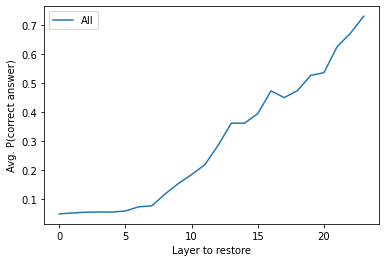

In [243]:
fig, ax = plt.subplots(1, 1)
ax.plot(all_avg_by_layer, label='All')
ax.set_xlabel('Layer to restore')
ax.set_ylabel('Avg. P(correct answer)')
ax.legend()

####  by hardness 

In [244]:
# {h : [[score], ...]}
scores_by_hardness = {hardness : [] for hardness in ['easy', 'medium', 'hard', 'extra']}   

for r in good_trace_results:
    enc_s, dec_s = r['scores']
    scores, = enc_s
#     hardness = spider_id2hardness[r['ex_id']]
    hardness = r['category']['sql_hardness']
    scores_by_hardness[hardness].append(scores)

[(h, len(scores)) for h, scores in scores_by_hardness.items()]

[('easy', 191), ('medium', 516), ('hard', 216), ('extra', 161)]

In [245]:
for h, sample_scores in scores_by_hardness.items():
    print(h)
    scores_by_layer = zip(*sample_scores)
    avg_by_layer = [np.mean(scores) for scores in scores_by_layer]
    print([f'{avg:.2f}' for avg in avg_by_layer])
    print()

easy
['0.05', '0.05', '0.06', '0.06', '0.06', '0.06', '0.08', '0.09', '0.14', '0.20', '0.24', '0.29', '0.35', '0.41', '0.40', '0.43', '0.49', '0.48', '0.50', '0.54', '0.55', '0.65', '0.71', '0.78']

medium
['0.05', '0.05', '0.06', '0.06', '0.06', '0.06', '0.07', '0.07', '0.11', '0.14', '0.17', '0.20', '0.27', '0.35', '0.35', '0.38', '0.45', '0.42', '0.45', '0.50', '0.51', '0.60', '0.65', '0.71']

hard
['0.04', '0.05', '0.05', '0.05', '0.05', '0.05', '0.06', '0.07', '0.11', '0.14', '0.17', '0.21', '0.27', '0.35', '0.37', '0.41', '0.49', '0.47', '0.48', '0.54', '0.54', '0.60', '0.65', '0.71']

extra
['0.06', '0.06', '0.07', '0.07', '0.07', '0.07', '0.09', '0.10', '0.13', '0.16', '0.19', '0.22', '0.28', '0.35', '0.35', '0.38', '0.50', '0.48', '0.52', '0.58', '0.60', '0.70', '0.72', '0.74']



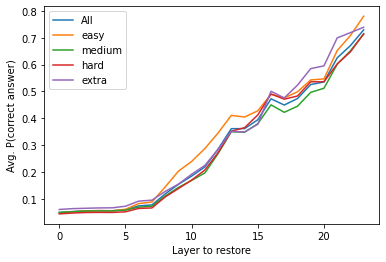

In [246]:
fig, ax = plt.subplots()
ax.plot(all_avg_by_layer, label='All')
for h, sample_scores in scores_by_hardness.items():
    h_scores_by_layer = zip(*sample_scores)
    h_avg_by_layer = [np.mean(scores) for scores in h_scores_by_layer]
    ax.plot(h_avg_by_layer, label=h)
ax.set_xlabel('Layer to restore')
ax.set_ylabel('Avg. P(correct answer)')
ax.legend()

####  by node role 

In [247]:
# {h : [[score], ...]}
scores_by_node_role = defaultdict(list)

for r in good_trace_results:
    enc_s, dec_s = r['scores']
    scores, = enc_s
#     role = _detect_node_role(' '.join(r['dec_input_tokens']))
    role = r['category']['node_role']
    scores_by_node_role[role].append(scores)

[(r, len(scores)) for r, scores in scores_by_node_role.items()]

[('select', 642),
 ('order by', 73),
 ('where', 267),
 ('group by', 26),
 ('join', 62),
 ('having', 4),
 ('from', 10)]

In [248]:
for r, sample_scores in scores_by_node_role.items():
    if len(sample_scores) < 10:
        continue
    print(r)
    scores_by_layer = zip(*sample_scores)
    avg_by_layer = [np.mean(scores) for scores in scores_by_layer]
    print([f'{avg:.2f}' for avg in avg_by_layer])
    print()

select
['0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.04', '0.04', '0.04', '0.06', '0.07', '0.09', '0.13', '0.18', '0.18', '0.20', '0.28', '0.26', '0.29', '0.35', '0.37', '0.54', '0.62', '0.72']

order by
['0.05', '0.05', '0.05', '0.05', '0.05', '0.05', '0.06', '0.06', '0.07', '0.09', '0.13', '0.17', '0.29', '0.50', '0.49', '0.59', '0.71', '0.63', '0.65', '0.74', '0.75', '0.76', '0.75', '0.77']

where
['0.08', '0.09', '0.10', '0.10', '0.10', '0.12', '0.16', '0.17', '0.30', '0.40', '0.47', '0.54', '0.65', '0.75', '0.76', '0.81', '0.89', '0.87', '0.87', '0.91', '0.91', '0.88', '0.88', '0.88']

group by
['0.15', '0.16', '0.18', '0.18', '0.18', '0.18', '0.20', '0.21', '0.30', '0.40', '0.46', '0.50', '0.65', '0.74', '0.71', '0.77', '0.87', '0.81', '0.85', '0.88', '0.86', '0.80', '0.85', '0.88']

join
['0.06', '0.06', '0.06', '0.06', '0.06', '0.06', '0.06', '0.06', '0.06', '0.07', '0.07', '0.09', '0.15', '0.22', '0.23', '0.25', '0.33', '0.30', '0.31', '0.33', '0.30', '0.27', '0.26', '0.

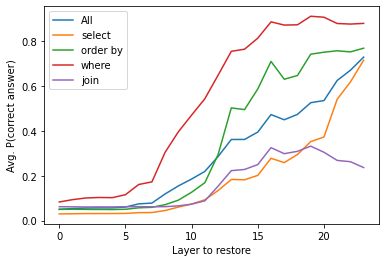

In [249]:
fig, ax = plt.subplots()
ax.plot(all_avg_by_layer, label='All')
for r, sample_scores in scores_by_node_role.items():
    if len(sample_scores) < 50:
        continue
    r_scores_by_layer = zip(*sample_scores)
    r_avg_by_layer = [np.mean(scores) for scores in r_scores_by_layer]
    ax.plot(r_avg_by_layer, label=r)
ax.set_xlabel('Layer to restore')
ax.set_ylabel('Avg. P(correct answer)')
ax.legend()

#### by text matching

In [250]:
scores_by_text_matching = {k: [] for k in ['exact', 'partial', 'no-match']}

for r in good_trace_results:
#     spider_ex = processed_spider_dev[r['ex_id']]
#     col = r['target_node']
#     tab = r['target_node_table']
#     m = ctu.check_text_match(spider_ex, col, tab)
    m = r['category']['text_match']

    enc_s, dec_s = r['scores']
    scores, = enc_s
    scores_by_text_matching[m].append(scores)

[(m, len(samples)) for m, samples in scores_by_text_matching.items()]

[('exact', 613), ('partial', 170), ('no-match', 301)]

In [251]:
for r, sample_scores in scores_by_text_matching.items():
    if len(sample_scores) < 10:
        continue
    print(r)
    scores_by_layer = zip(*sample_scores)
    avg_by_layer = [np.mean(scores) for scores in scores_by_layer]
    print([f'{avg:.2f}' for avg in avg_by_layer])
    print()

exact
['0.05', '0.06', '0.06', '0.06', '0.06', '0.06', '0.08', '0.08', '0.13', '0.17', '0.20', '0.24', '0.29', '0.35', '0.35', '0.38', '0.46', '0.43', '0.45', '0.51', '0.53', '0.63', '0.68', '0.75']

partial
['0.05', '0.05', '0.05', '0.05', '0.05', '0.05', '0.05', '0.06', '0.07', '0.09', '0.12', '0.14', '0.22', '0.32', '0.32', '0.36', '0.44', '0.44', '0.47', '0.52', '0.52', '0.62', '0.67', '0.73']

no-match
['0.05', '0.05', '0.05', '0.05', '0.05', '0.06', '0.08', '0.08', '0.13', '0.15', '0.19', '0.23', '0.31', '0.41', '0.41', '0.44', '0.52', '0.50', '0.52', '0.57', '0.56', '0.61', '0.65', '0.70']



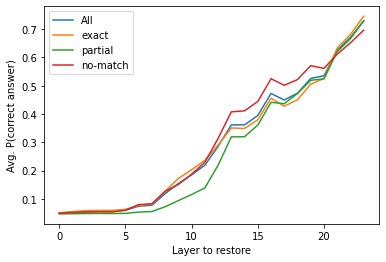

In [252]:
fig, ax = plt.subplots()
ax.plot(all_avg_by_layer, label='All')
for m, sample_scores in scores_by_text_matching.items():
    if len(sample_scores) < 10:
        continue
    r_scores_by_layer = zip(*sample_scores)
    r_avg_by_layer = [np.mean(scores) for scores in r_scores_by_layer]
    ax.plot(r_avg_by_layer, label=m)
ax.set_xlabel('Layer to restore')
ax.set_ylabel('Avg. P(correct answer)')
ax.legend()

### Exp-3.1: dirty struct context restore

#### Load & Check results

In [159]:
res_path = '/home/yshao/Projects/rome/results/exp3.1_dirty_struct_context_restore/exp=3.1_dev_table-tmp.jsonl'

with open(res_path, 'r') as f:
    all_samples = [json.loads(l) for l in f]
len(all_samples)

10

In [160]:
all_samples[0]

{'ex_id': 0,
 'trace_results': [{'enc_sentence': 'How many singers do we have?; structed knowledge: | concert_singer | stadium : stadium_id , location , name , capacity , highest , lowest , average | singer : singer_id , name , country , song_name , song_release_year , age , is_male | concert : concert_id , concert_name , theme , stadium_id , year | singer_in_concert : concert_id , singer_id',
   'seq_out': 'select count(*) from singer',
   'dec_prompt': 'select count(*) from',
   'expect': 'singer',
   'expect_type': 'table',
   'db_id': 'concert_singer',
   'expect_input_ranges': [[47, 48]],
   'expect_table': 'singer',
   'answer': 'singer',
   'base_score': 0.9999998807907104,
   'answers_t': [7634],
   'correct_prediction': True,
   'category': {'sql_hardness': 'easy',
    'node_role': 'from',
    'text_match': 'exact'},
   'self_ranges': [[46, 50]],
   'struct_context_ranges': [[15, 46], [50, 125]],
   'trace_scores': {'single_layer_corrupt': {},
    'low_layers_restore': {},
   

In [156]:
total_samples = 0
n_good_samples = 0
n_too_hard = 0      # wrong answer 
n_too_easy = 0      # base - low < 0.5

In [157]:
good_samples = []
bad_samples = []

for i, ex in enumerate(all_samples):
    for d in ex['trace_results']:
        total_samples += 1
        if d['is_good_sample']:
            n_good_samples += 1
            d['ex_id'] = i
            good_samples.append(d)
        elif not d['correct_prediction']:
            n_too_hard += 1
            bad_samples.append(d)
        else:
            assert d['base_score'] - d['low_score'] < 0.5
            n_too_easy += 1
            bad_samples.append(d)
            
total_samples, (n_good_samples, len(good_samples)), n_too_hard, n_too_easy, len(bad_samples)

(18, (0, 0), 2, 16, 18)

In [158]:
for d in good_samples:
    print(d['enc_sentence'])
    print(d['dec_prompt'], '-->', d['expect'])
    print(json.dumps(d['trace_scores'], indent=1))

In [ ]:
for d in bad_samples:
    print(d['enc_sentence'])
    print(d['dec_prompt'], '-->', d['expect'])
    print()

### Exp-3.2: dirty struct context compare

#### Load & Check results

In [221]:
res_path = '/home/yshao/Projects/rome/results/exp3.2_dirty_struct_context_compare/exp=3.2_dev_table.jsonl'

with open(res_path, 'r') as f:
    all_samples = [json.loads(l) for l in f]
len(all_samples)

1034

In [222]:
all_samples[0]

{'ex_id': 0,
 'trace_results': [{'enc_sentence': 'How many singers do we have?; structed knowledge: | concert_singer | stadium : stadium_id , location , name , capacity , highest , lowest , average | singer : singer_id , name , country , song_name , song_release_year , age , is_male | concert : concert_id , concert_name , theme , stadium_id , year | singer_in_concert : concert_id , singer_id',
   'seq_out': 'select count(*) from singer',
   'dec_prompt': 'select count(*) from',
   'expect': 'singer',
   'expect_type': 'table',
   'db_id': 'concert_singer',
   'expect_input_ranges': [[47, 48]],
   'expect_table': 'singer',
   'answer': 'singer',
   'base_score': 0.9999998807907104,
   'answers_t': [7634],
   'correct_prediction': True,
   'category': {'sql_hardness': 'easy',
    'node_role': 'from',
    'text_match': 'exact'},
   'self_ranges': [[46, 50]],
   'struct_context_ranges': [[15, 46], [50, 125]],
   'scc_score': 1.0,
   'scc_answers_t': [7634],
   'scc_answer': 'singer',
   's

In [223]:
correctness_compare_counter = Counter([d['compare']['correctness_compare'] for ex in all_samples for d in ex['trace_results']])
correctness_compare_counter

Counter({'both': 1424, 'clean+': 123, 'scc+': 105, 'none': 31})

In [231]:
for i, ex in enumerate(all_samples):
    for d in ex['trace_results']:
        _comp = d['compare']['correctness_compare']
#         if _comp in {'scc+', 'clean+'}:
        if (_comp == 'scc+') and (d['category']['node_role'] != 'join'):
            print(f'#{i}:', d['enc_sentence'])
            print('SQL:', d['dec_prompt'], '-->', d['expect'])
            print('Clean:', d['answer'])
            print('SCC:', d['scc_answer'])
            print('COMP:', d['compare']['correctness_compare'])
            print()

#43: Find the number of concerts happened in the stadium with the highest capacity .; structed knowledge: | concert_singer | stadium : stadium_id , location , name , capacity , highest , lowest , average | singer : singer_id , name , country , song_name , song_release_year , age , is_male | concert : concert_id , concert_name , theme , stadium_id , year | singer_in_concert : concert_id , singer_id
SQL: select count(*) from --> concert
Clean: stadium
SCC: concert
COMP: scc+

#44: What are the number of concerts that occurred in the stadium with the largest capacity ?; structed knowledge: | concert_singer | stadium : stadium_id , location , name , capacity , highest , lowest , average | singer : singer_id , name , country , song_name , song_release_year , age , is_male | concert : concert_id , concert_name , theme , stadium_id , year | singer_in_concert : concert_id , singer_id
SQL: select count(*) from --> concert
Clean: stadium
SCC: concert
COMP: scc+

#51: Find number of pets owned by

In [226]:
_clean_node_role_cnt = Counter()
# TODO: make a larger counter: {comp -> category_k -> category_v -> count}

for i, ex in enumerate(all_samples):
    for d in ex['trace_results']:
        if d['compare']['correctness_compare'] == 'clean+':
            _role = d['category']['node_role']
            _clean_node_role_cnt[_role] += 1

_clean_node_role_cnt

Counter({'join': 83, 'from': 40})

In [227]:
_scc_node_role_cnt = Counter()

for i, ex in enumerate(all_samples):
    for d in ex['trace_results']:
        if d['compare']['correctness_compare'] == 'scc+':
            _role = d['category']['node_role']
            _scc_node_role_cnt[_role] += 1

_scc_node_role_cnt

Counter({'from': 73, 'join': 32})

### Exp-4: inspect attention

In [20]:
res_path = '/home/yshao/Projects/rome/results/exp4_inspect_attention/exp=4_dev_column_both.jsonl'

with open(res_path, 'r') as f:
    all_samples = [json.loads(l) for l in f]
len(all_samples)

104

In [21]:
all_samples[1]['trace_results'][0].keys()

dict_keys(['enc_sentence', 'seq_out', 'dec_prompt', 'expect', 'expect_type', 'db_id', 'expect_input_ranges', 'expect_table', 'category', 'answer', 'probs', 'base_score', 'answers_t', 'correct_prediction', 'attentions'])

In [22]:
d = all_samples[6]['trace_results'][0]
d['enc_sentence'], d['dec_prompt'], d['expect']

("What are the students' first names who have both cats and dogs as pets?; structed knowledge: | pets_1 | student : stuid , lname , fname , age , sex , major , advisor , city_code | has_pet : stuid , petid | pets : petid , pettype ( dog , cat ) , pet_age , weight",
 'select t1.',
 'fname')

In [23]:
d.keys(), d['attentions'].keys(), d['attentions']['enc'].keys()

(dict_keys(['enc_sentence', 'seq_out', 'dec_prompt', 'expect', 'expect_type', 'db_id', 'expect_input_ranges', 'expect_table', 'category', 'answer', 'probs', 'base_score', 'answers_t', 'correct_prediction', 'attentions']),
 dict_keys(['enc', 'cross', 'dec']),
 dict_keys(['attn', 'head_tokens', 'cand_tokens']))

#### Plotting

In [24]:
def _draw_single_plot_2(ax, val_mat, x_labels=None, y_labels=None, title=None):
    """
    X: # heads
    Y: cand tokens
    Title: head token (together with full expect)
    """
    if isinstance(val_mat, list):
        val_mat = numpy.array(val_mat)
    h = ax.pcolormesh(
        val_mat,
        cmap="Reds",
        vmax=1.0,
        vmin=0.0,
    )
    ax.invert_yaxis()
    ax.set_yticks([0.5 + i for i in range(val_mat.shape[0])])
    ax.set_xticks([0.5 + i for i in range(val_mat.shape[1])])
    if x_labels is not None:
        ax.set_xticklabels(x_labels, fontsize=8)
    if y_labels is not None:
        ax.set_yticklabels(y_labels, fontsize=8)

    if title is not None:
        ax.set_title(title)
    ax.set_xlabel(f"# Head")
    ax.set_ylabel(f"Attention candidate tokens")
    
    # cb = plt.colorbar(h)
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes('right', size='5%', pad=0.05)
    # cb = fig.colorbar(h, cax=cax)
    cb = plt.colorbar(h, ax=ax)

#     if xlabel is not None:
#         ax.set_xlabel(xlabel)
#     elif answer is not None:
#         # The following should be cb.ax.set_xlabel, but this is broken in matplotlib 3.5.1.
#         cb.ax.set_title(f"p({str(answer).strip()})", y=-0.16, fontsize=10)

In [25]:
def plot_uskg_attention(d, att_part, savepdf=None):
    """
    Assume 16 heads, 24 layers (T5 large config)
    
    att_part: enc, cross, dec 
    """
    
    ## encoder self attention 
    inspect_layers = [0, 6, 12, 18, 23]
    att_dict = d['attentions'][att_part]
    
    cand_len = len(att_dict['cand_tokens'])
    head_len = len(att_dict['head_tokens'])
    prompt_tokens = d['attentions']['dec']['cand_tokens']
    prompt_len = len(prompt_tokens)

    fig_w = 22
    fig_h = (0.11*cand_len + 1) * head_len + 2
    fig, ax_list = plt.subplots(
        nrows=head_len,
        ncols=len(inspect_layers),
        squeeze=False,
        figsize=(fig_w, fig_h))

    att_mat = ctu.nested_list_processing(att_dict['attn'], func=float)
    att_mat = np.array(att_mat)
    
    for expect_i in range(len(att_dict['head_tokens'])):
        for l_id, layer in enumerate(inspect_layers):
            val_mat = att_mat[layer, :, expect_i, :]  # layer, all heads, expect tok i -> all toks 
            val_mat = val_mat.transpose()    # (cand_toks, n_heads)
            x_labels = range(val_mat.shape[1])
            y_labels = att_dict['cand_tokens']
            if att_part == 'enc':
                # enc: correct tokens
                title_toks = att_dict['head_tokens'][:expect_i] + [f"*{att_dict['head_tokens'][expect_i]}*"]
            else:
                # cross / dec: use gold tokens from dec_prompt for previous steps and predicted token at this step
                # (dec_prompt ends with the first (head_len-1) tokens of the target node)
                title_toks = prompt_tokens[prompt_len - (head_len-1) : prompt_len - (head_len-1) + expect_i] + [f"*{att_dict['head_tokens'][expect_i]}*"]
            
            title = f"L{layer}  Head token: {' '.join(title_toks)}\n"
            
            ax = ax_list[expect_i, l_id]
            _draw_single_plot_2(ax,
                                val_mat=val_mat, 
                                x_labels=x_labels, 
                                y_labels=y_labels,
                                title=title)
            
    fig.tight_layout()
    if savepdf:
        plt.savefig(savepdf, bbox_inches="tight")
        plt.close()
    else:
        plt.show()

In [ ]:
# savepdf_tmpl = '/home/yshao/Projects/rome/results/figs/exp4_inspect_attention/tmp-6-{}.pdf'
# for att_part in ['enc', 'cross', 'dec']:
#     plot_uskg_attention(d, att_part, savepdf=savepdf_tmpl.format(att_part))

In [27]:
## Run for all! 

fig_dir  = '/home/yshao/Projects/rome/results/figs/exp4_inspect_attention/dev_column'
os.makedirs(fig_dir, exist_ok=True)

global_ex_id = 0
for ex_id in tqdm(range(len(all_samples))):
    for a_ex_id in range(len(all_samples[ex_id]['trace_results'])):
        d = all_samples[ex_id]['trace_results'][a_ex_id]
        for att_part in ['enc', 'cross', 'dec']:
            savepdf_path = os.path.join(fig_dir, f'{global_ex_id}-ex={ex_id}.{a_ex_id}-{att_part}.pdf')
            plot_uskg_attention(d, att_part, savepdf=savepdf_path)
        # print(f'{global_ex_id}-ex={ex_id}.{a_ex_id}')
        global_ex_id += 1

  0%|          | 0/104 [00:00<?, ?it/s]

#### Exp-4.0.1: Prefix attention samples
- Check the samples with high attention on a given layer & head & prefix token
- Haven't found any insights...

In [63]:
total_a_ex = 0
total_tok_sample = 0

for ex_id in (range(len(all_samples))):
    for a_ex_id in range(len(all_samples[ex_id]['trace_results'])):
        d = all_samples[ex_id]['trace_results'][a_ex_id]
        _expect_len = len([i for s, e in d['expect_input_ranges'] for i in range(s, e)])
        
        total_a_ex += 1
        total_tok_sample += _expect_len

total_a_ex, total_tok_sample

(198, 680)

In [57]:
d = all_samples[6]['trace_results'][0]
d['enc_sentence'], d['dec_prompt'], d['expect']

("What are the students' first names who have both cats and dogs as pets?; structed knowledge: | pets_1 | student : stuid , lname , fname , age , sex , major , advisor , city_code | has_pet : stuid , petid | pets : petid , pettype ( dog , cat ) , pet_age , weight",
 'select t1.',
 'fname')

In [61]:
_expect_len = len([i for s, e in d['expect_input_ranges'] for i in range(s, e)])
d['expect_input_ranges'], _expect_len

([[41, 44]], 3)

In [52]:
enc_prefix_att_samples = defaultdict(list)  # [(l_id, head_id, prefix_id) -> [dict(ex_id, a_ex_id, tok_id, ...)]]

for ex_id in tqdm(range(len(all_samples))):
    for a_ex_id in range(len(all_samples[ex_id]['trace_results'])):
# for ex_id in [6]:
#     for a_ex_id in [0]:
        d = all_samples[ex_id]['trace_results'][a_ex_id]
        
        att_mat = ctu.nested_list_processing(d['attentions']['enc']['attn'], func=float)
        # att_mat: (n_layers, n_heads, n_expect_toks, n_input_toks)
        att_mat = np.array(att_mat)
        n_layers, n_heads, n_expect_toks, n_input_toks = att_mat.shape
        
        # (n_layers, n_heads, expect_toks)
#         input_att_positions = np.argmax(att_mat, axis=-1)
#         for l_id in range(n_layers):
#             for h_id in range(n_heads):
#                 for tok_id in range(n_expect_toks):
#                     _max_att_p = input_att_positions[l_id, h_id, tok_id]

        input_att_positions = np.where(att_mat > 0.5)
        for l_id, h_id, tok_id, _max_att_p in zip(*input_att_positions):
            if _max_att_p < 10:
                # is prefix 
                enc_prefix_att_samples[(l_id, h_id, _max_att_p)].append({
                    'ex_id': ex_id,
                    'a_ex_id': a_ex_id,
                    'expect_tok_id': tok_id,
                    'enc_sentence': d['enc_sentence'],
                    'dec_prompt': d['dec_prompt'],
                    'expect': d['expect'],
                })

  0%|          | 0/104 [00:00<?, ?it/s]

In [53]:
len(enc_prefix_att_samples)

1873

In [54]:
len_profile_counter = Counter([len(v) for k, v in enc_prefix_att_samples.items()])
sorted(len_profile_counter.items())

[(1, 270),
 (2, 214),
 (3, 139),
 (4, 127),
 (5, 92),
 (6, 92),
 (7, 59),
 (8, 61),
 (9, 48),
 (10, 42),
 (11, 47),
 (12, 37),
 (13, 43),
 (14, 42),
 (15, 31),
 (16, 32),
 (17, 29),
 (18, 28),
 (19, 14),
 (20, 17),
 (21, 14),
 (22, 16),
 (23, 13),
 (24, 15),
 (25, 16),
 (26, 14),
 (27, 26),
 (28, 7),
 (29, 15),
 (30, 16),
 (31, 10),
 (32, 9),
 (33, 4),
 (34, 7),
 (35, 9),
 (36, 8),
 (37, 8),
 (38, 15),
 (39, 9),
 (40, 5),
 (41, 9),
 (42, 5),
 (43, 1),
 (44, 10),
 (45, 3),
 (46, 2),
 (47, 2),
 (48, 5),
 (49, 8),
 (50, 1),
 (51, 4),
 (52, 1),
 (53, 3),
 (54, 4),
 (55, 4),
 (57, 2),
 (58, 1),
 (59, 1),
 (60, 5),
 (61, 4),
 (62, 1),
 (63, 3),
 (64, 3),
 (65, 4),
 (66, 3),
 (67, 3),
 (68, 4),
 (70, 3),
 (71, 2),
 (72, 1),
 (73, 5),
 (74, 1),
 (76, 3),
 (77, 2),
 (78, 1),
 (79, 2),
 (80, 1),
 (81, 1),
 (82, 2),
 (83, 2),
 (84, 1),
 (85, 3),
 (86, 4),
 (87, 2),
 (88, 1),
 (89, 1),
 (90, 2),
 (92, 1),
 (94, 2),
 (95, 1),
 (96, 2),
 (97, 2),
 (98, 3),
 (99, 1),
 (100, 1),
 (102, 1),
 (105, 1),


In [55]:
for k, v in enc_prefix_att_samples.items():
    if len(v) > 120:
        print(k, len(v))

(18, 5, 4) 192
(18, 6, 2) 145
(20, 0, 7) 136
(20, 4, 8) 198
(23, 7, 0) 125
(8, 5, 0) 140
(15, 5, 4) 235
(17, 1, 9) 220
(19, 10, 1) 177
(21, 12, 5) 131
(3, 4, 8) 126
(11, 8, 4) 124
(21, 0, 1) 129


In [56]:
enc_prefix_att_samples[(23, 7, 0)]

[{'ex_id': 1,
  'a_ex_id': 0,
  'expect_tok_id': 0,
  'enc_sentence': 'Show all countries and the number of singers in each country.; structed knowledge: | concert_singer | stadium : stadium_id , location , name , capacity , highest , lowest , average | singer : singer_id , name , country , song_name , song_release_year , age , is_male | concert : concert_id , concert_name , theme , stadium_id , year | singer_in_concert : concert_id , singer_id',
  'dec_prompt': 'select',
  'expect': 'country'},
 {'ex_id': 1,
  'a_ex_id': 1,
  'expect_tok_id': 0,
  'enc_sentence': 'Show all countries and the number of singers in each country.; structed knowledge: | concert_singer | stadium : stadium_id , location , name , capacity , highest , lowest , average | singer : singer_id , name , country , song_name , song_release_year , age , is_male | concert : concert_id , concert_name , theme , stadium_id , year | singer_in_concert : concert_id , singer_id',
  'dec_prompt': 'select country, count(*) from s

## USKG error analysis

In [335]:
# adapted from play_pred()

def pred_sql(mt, ex):
    text_in = ex['text_in']
    struct_in = ex['struct_in']

    txt = f"{text_in}; structed knowledge: {struct_in}"
    
    tokenized_txt = mt.tokenizer_uskg([txt], max_length=1024, padding="max_length", truncation=True)
    
    device = mt.model.device
    pred = mt.tokenizer_uskg.batch_decode(
      mt.model.generate(
        torch.tensor(tokenized_txt.data['input_ids'], dtype=int, device=device),
        torch.tensor(tokenized_txt.data['attention_mask'], dtype=int, device=device),
        num_beams=1, 
        max_length=256
        ), 
      skip_special_tokens=True 
    )
    return pred[0]


In [336]:
# adapted from evaluator.evaluate_one()

def evaluate_sql(evaluator, db_name, gold, predicted):
    schema = evaluator.schemas[db_name]
    g_sql = sp_eval.get_sql(schema, gold)
    hardness = evaluator.eval_hardness(g_sql)
    # self.scores[hardness]["count"] += 1
    # self.scores["all"]["count"] += 1

    parse_error = False
    try:
        p_sql = sp_eval.get_sql(schema, predicted)
    except:
        # If p_sql is not valid, then we will use an empty sql to evaluate with the correct sql
        p_sql = {
            "except": None,
            "from": {"conds": [], "table_units": []},
            "groupBy": [],
            "having": [],
            "intersect": None,
            "limit": None,
            "orderBy": [],
            "select": [False, []],
            "union": None,
            "where": [],
        }

        # TODO fix
        parse_error = True

    # rebuild sql for value evaluation
    kmap = evaluator.kmaps[db_name]
    g_valid_col_units = sp_eval.build_valid_col_units(g_sql["from"]["table_units"], schema)
    g_sql = sp_eval.rebuild_sql_val(g_sql)
    g_sql = sp_eval.rebuild_sql_col(g_valid_col_units, g_sql, kmap)
    p_valid_col_units = sp_eval.build_valid_col_units(p_sql["from"]["table_units"], schema)
    p_sql = sp_eval.rebuild_sql_val(p_sql)
    p_sql = sp_eval.rebuild_sql_col(p_valid_col_units, p_sql, kmap)
    
    exec_score = None
    partial_scores = None
    exact_score = None
    if evaluator.etype in ["all", "exec"]:
        exec_score = sp_eval.eval_exec_match(
            evaluator.db_paths[db_name], predicted, gold, p_sql, g_sql
        )
        exec_score = int(exec_score)
    if evaluator.etype in ["all", "match"]:
        partial_scores = evaluator.eval_partial_match(p_sql, g_sql)
        exact_score = evaluator.eval_exact_match(p_sql, g_sql, partial_scores)
        # update_scores_match(self.scores, exact_score, hardness, partial_scores, PARTIAL_TYPES)

    return {
        "predicted": predicted,
        "gold": gold,
        "predicted_parse_error": parse_error,
        "hardness": hardness,
        "exact": exact_score,
        "partial": partial_scores,
        "exec": exec_score,
    }

In [354]:
db_dir = '/home/yshao/Projects/language/language/xsp/data/spider/database'

def execute_sql(db, sql_str):
    db_path = os.path.join(db_dir, db, f'{db}.sqlite')
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    try:
        cursor.execute(sql_str)
        res = cursor.fetchall()
    except:
        res = 'ERROR'
    conn.close()
    return res

In [403]:
ex = processed_spider_dev[503]
ex.keys()

dict_keys(['query', 'question', 'db_id', 'db_path', 'db_table_names', 'db_column_names', 'db_column_types', 'db_primary_keys', 'db_foreign_keys', 'rat_sql_graph', 'serialized_schema', 'struct_in', 'text_in', 'seq_out'])

In [404]:
pred = pred_sql(mt_uskg, ex)
ex['db_id'], ex['text_in'], ex['seq_out'], pred

('battle_death',
 "How many battles did not lose any ship with tonnage '225'?",
 "select count(*) from battle where id not in ( select lost_in_battle from ship where tonnage = '225' );",
 'select count(*) from battle where id not in ( select lost_in_battle from ship where tonnage > 225 )')

In [ ]:
text_in = ex['text_in']
struct_in = ex['struct_in']
txt = f"{text_in}; structed knowledge: {struct_in}"
txt_toks = mt_uskg.tokenizer_uskg.tokenize(txt)
len(txt_toks)

In [ ]:
txt_toks

In [405]:
exec_res = execute_sql(ex['db_id'], ex['seq_out'])
ex['seq_out'], exec_res

("select count(*) from battle where id not in ( select lost_in_battle from ship where tonnage = '225' );",
 [(7,)])

In [406]:
exec_res = execute_sql(ex['db_id'], pred)
pred, exec_res

('select count(*) from battle where id not in ( select lost_in_battle from ship where tonnage > 225 )',
 [(3,)])

In [407]:
chatgpt_pred = """
SELECT COUNT(DISTINCT battle.id) AS num_battles
FROM battle
LEFT JOIN ship ON battle.id = ship.lost_in_battle
WHERE (ship.tonnage != '225' OR ship.tonnage IS NULL)
"""

execute_sql(ex['db_id'], chatgpt_pred)

[(8,)]

In [339]:
eval_res = evaluate_sql(evaluator, db_name=spider_ex['db_id'], gold=spider_ex['seq_out'], predicted=pred)

In [340]:
eval_res

{'predicted': 'select avg(num_of_staff) from museum where open_year  < 2009',
 'gold': 'select avg(num_of_staff) from museum where open_year < 2009',
 'predicted_parse_error': False,
 'hardness': 'easy',
 'exact': True,
 'partial': {'select': {'acc': 1,
   'rec': 1,
   'f1': 1,
   'label_total': 1,
   'pred_total': 1},
  'select(no AGG)': {'acc': 1,
   'rec': 1,
   'f1': 1,
   'label_total': 1,
   'pred_total': 1},
  'where': {'acc': 1, 'rec': 1, 'f1': 1, 'label_total': 1, 'pred_total': 1},
  'where(no OP)': {'acc': 1,
   'rec': 1,
   'f1': 1,
   'label_total': 1,
   'pred_total': 1},
  'group(no Having)': {'acc': 1,
   'rec': 1,
   'f1': 1,
   'label_total': 0,
   'pred_total': 0},
  'group': {'acc': 1, 'rec': 1, 'f1': 1, 'label_total': 0, 'pred_total': 0},
  'order': {'acc': 1, 'rec': 1, 'f1': 1, 'label_total': 0, 'pred_total': 0},
  'and/or': {'acc': 1, 'rec': 1, 'f1': 1, 'label_total': 1, 'pred_total': 1},
  'IUEN': {'acc': 1, 'rec': 1, 'f1': 1, 'label_total': 0, 'pred_total': 0},


In [411]:
# Eval all 
# TODO: rerun with tokenizer_uskg decoding 

eval_sql_results = []

for ex_id, ex in enumerate(tqdm(processed_spider_dev)):
    pred = pred_sql(mt_uskg, ex)
    eval_res = evaluate_sql(evaluator, db_name=ex['db_id'], gold=ex['seq_out'], predicted=pred)
    eval_sql_results.append(eval_res)
    

  0%|          | 0/1034 [00:00<?, ?it/s]

In [412]:
avg_exact = np.mean([d['exact'] for d in eval_sql_results])
avg_exec = np.mean([d['exec'] for d in eval_sql_results])
avg_exact, avg_exec

(0.6692456479690522, 0.6808510638297872)

In [ ]:
for i, d in enumerate(eval_sql_results):
    if d['exact'] and d['exec']:
        continue
    err_msg = ('A' if not d['exact'] else '') + ('X' if not d['exec'] else '')
    ex = processed_spider_dev[i]
    print(f'ID = {i}: {err_msg}  ({ex["db_id"]}) {ex["text_in"]}')
    print(f'Pred: {d["predicted"]}')
    print(f'Gold: {d["gold"]}')
    print()

In [ ]:
evaluator.schemas['dog_kennels'].schema

In [414]:
# acc by db_id 
eval_sql_results_by_db_id = defaultdict(list)

for i, d in enumerate(eval_sql_results):
    d['ex_id'] = i
    ex = processed_spider_dev[i]
    db_id = ex['db_id']
    eval_sql_results_by_db_id[db_id].append(d)

len(eval_sql_results_by_db_id)

20

In [415]:
for db_id, results in eval_sql_results_by_db_id.items():
    _avg_exact = np.mean([d['exact'] for d in results])
    _avg_exec = np.mean([d['exec'] for d in results])
    print(f'{db_id}\t{_avg_exact:.4f}\t{_avg_exec:.4f}')

concert_singer	0.8889	0.8889
pets_1	0.5714	0.7381
car_1	0.3478	0.3913
flight_2	0.7000	0.7500
employee_hire_evaluation	0.9474	0.9737
cre_Doc_Template_Mgt	0.8333	0.9048
course_teach	0.8667	0.9333
museum_visit	0.7222	0.8333
wta_1	0.6774	0.6129
battle_death	0.5000	0.5000
student_transcripts_tracking	0.6667	0.6795
tvshow	0.7258	0.6613
poker_player	0.8750	0.8750
voter_1	0.6000	0.6667
world_1	0.5083	0.4833
orchestra	0.8000	0.8750
network_1	0.6250	0.4643
dog_kennels	0.5854	0.5976
singer	0.8667	0.8667
real_estate_properties	0.5000	0.5000


## Model intermediate inspect

In [282]:
[k for k, v in mt_uskg.model.named_parameters()]

['pretrain_model.shared.weight',
 'pretrain_model.encoder.block.0.layer.0.SelfAttention.q.weight',
 'pretrain_model.encoder.block.0.layer.0.SelfAttention.k.weight',
 'pretrain_model.encoder.block.0.layer.0.SelfAttention.v.weight',
 'pretrain_model.encoder.block.0.layer.0.SelfAttention.o.weight',
 'pretrain_model.encoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight',
 'pretrain_model.encoder.block.0.layer.0.layer_norm.weight',
 'pretrain_model.encoder.block.0.layer.1.DenseReluDense.wi.weight',
 'pretrain_model.encoder.block.0.layer.1.DenseReluDense.wo.weight',
 'pretrain_model.encoder.block.0.layer.1.layer_norm.weight',
 'pretrain_model.encoder.block.1.layer.0.SelfAttention.q.weight',
 'pretrain_model.encoder.block.1.layer.0.SelfAttention.k.weight',
 'pretrain_model.encoder.block.1.layer.0.SelfAttention.v.weight',
 'pretrain_model.encoder.block.1.layer.0.SelfAttention.o.weight',
 'pretrain_model.encoder.block.1.layer.0.layer_norm.weight',
 'pretrain_model.encoder.block.1

### Self-attention

In [284]:
_t5_config = mt_uskg.model.config
type(_t5_config)

transformers.models.t5.configuration_t5.T5Config

In [286]:
_t5_config

T5Config {
  "_name_or_path": "t5-large",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 4096,
  "d_kv": 64,
  "d_model": 1024,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "gradient_checkpointing": false,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 24,
  "num_heads": 16,
  "num_layers": 24,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "translation_en_to_de": {
      "early_stopping": true,
      "max_length": 300,
      "num_beams": 4,
      "prefix": "translate English to German: "
    },
    "transl

In [306]:
sa_module = uskg.models.prompt.modeling_t5.T5Attention(_t5_config)
sa_module.eval()
sa_module

T5Attention(
  (q): Linear(in_features=1024, out_features=1024, bias=False)
  (k): Linear(in_features=1024, out_features=1024, bias=False)
  (v): Linear(in_features=1024, out_features=1024, bias=False)
  (o): Linear(in_features=1024, out_features=1024, bias=False)
)

In [307]:
sa_module.__dict__

{'training': False,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_modules': OrderedDict([('q',
               Linear(in_features=1024, out_features=1024, bias=False)),
              ('k', Linear(in_features=1024, out_features=1024, bias=False)),
              ('v', Linear(in_features=1024, out_features=1024, bias=False)),
              ('o', Linear(in_features=1024, out_features=1024, bias=False))]),
 'is_decoder': False,
 'has_relative_attention_bias': False,
 'relative_attention_num_buckets': 32,
 'd_model': 1024,
 'key_value_proj_dim': 64,
 'n_heads': 16,
 'dropout': 0.1,
 'inner_dim': 1024,
 'pruned_heads': set(),
 'gradient_checkpointing': False}

In [308]:
bsz = 3
seq_len = 10
dim = 1024
fake_sa_input = torch.zeros(bsz, seq_len, dim)

In [309]:
attn_output, present_key_value_state, position_bias, attn_weights = sa_module(fake_sa_input, output_attentions=True)

In [310]:
attn_output.size()

torch.Size([3, 10, 1024])

In [311]:
present_key_value_state

In [312]:
attn_weights.size()

torch.Size([3, 16, 10, 10])

In [313]:
position_bias.size()

torch.Size([1, 16, 10, 10])

In [314]:
attn_weights

tensor([[[[0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
          ...,
          [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000]],

         [[0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
          ...,
          [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000]],

         [[0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000,  ..., 0

## Tests

### create_analysis_samples

In [258]:
_id = 100

ex = processed_spider_dev[_id]
ex['text_in'], \
ex['struct_in'], \
ex['seq_out']

('What is the name of the different car makers who produced a car in 1970?',
 '| car_1 | continents : contid , continent | countries : countryid , countryname , continent | car_makers : id , maker , fullname , country | model_list : modelid , maker , model | car_names : makeid , model , make | cars_data : id , mpg , cylinders , edispl , horsepower , weight , accelerate , year',
 'select year from cars_data')

In [259]:
# temp test
ex['seq_out'] = 'select year from cars_data'

In [261]:
a_ex_list = ctu.create_analysis_sample_dicts(
                mt_uskg, ex,
                subject_type='column',
                remove_struct_duplicate_nodes=True)

In [262]:
a_ex_list[0].keys()

dict_keys(['query', 'question', 'db_id', 'db_path', 'db_table_names', 'db_column_names', 'db_column_types', 'db_primary_keys', 'db_foreign_keys', 'rat_sql_graph', 'serialized_schema', 'struct_in', 'text_in', 'seq_out', 'enc_sentence', 'enc_tokenized', 'text_range', 'struct_range', 'struct_node_ranges_dict', 'dec_prompt', 'expect', 'expect_type', 'remove_struct_duplicate_nodes', 'parsed_struct_in', 'col2table', 'token_ranges_dict', 'node_name_ranges', 'expect_input_ranges', 'alias2table', 'self_ranges', 'context_ranges', 'category'])

In [263]:
a_ex_list[0]['alias2table']

{}

In [267]:
[(d['dec_prompt'], d['expect'], d['node_name_ranges'], d['expect_input_ranges'], '------',\
  d['self_ranges'], d['context_ranges'],\
  d['category']) for d in a_ex_list]

[('select',
  'year',
  defaultdict(list,
              {'contid': [(33, 36)],
               'continent': [(38, 39), (52, 53)],
               'countryid': [(43, 46)],
               'countryname': [(48, 50)],
               'id': [(59, 62), (109, 112)],
               'maker': [(64, 65), (83, 84)],
               'fullname': [(67, 69)],
               'country': [(71, 72)],
               'modelid': [(78, 81)],
               'model': [(86, 87), (99, 100)],
               'makeid': [(94, 97)],
               'make': [(102, 103)],
               'mpg': [(114, 117)],
               'cylinders': [(119, 122)],
               'edispl': [(124, 128)],
               'horsepower': [(130, 131)],
               'weight': [(133, 134)],
               'accelerate': [(136, 137)],
               'year': [(139, 140)]}),
  [(139, 140)],
  '------',
  [(137, 140)],
  [(24, 137)],
  {'sql_hardness': 'easy', 'node_role': 'select', 'text_match': 'no-match'})]

In [ ]:
d = a_ex_list[0]
d

In [ ]:
d = ctu.add_clean_prediction(mt_uskg, d)

In [ ]:
d

#### parse_sql_alias2table

In [185]:
_sql = 'SELECT t2.aaa , t3.ccc FROM table_name as t1 JOIN other_table as t2 on table_name.a_a = other_table.b_a JOIN ttt as t3 on other_table.asth = ttt.asth'
ctu.parse_sql_alias2table(_sql)

{'t1': 'table_name', 't2': 'other_table', 't3': 'ttt'}

### context_ranges

In [249]:
a_ex = dict(a_ex_list[0])
a_ex['text_in'], a_ex['struct_in'], a_ex['seq_out'], a_ex['expect']

('What is the name of the different car makers who produced a car in 1970?',
 '| car_1 | continents : contid , continent | countries : countryid , countryname , continent | car_makers : id , maker , fullname , country | model_list : modelid , maker , model | car_names : makeid , model , make | cars_data : id , mpg , cylinders , edispl , horsepower , weight , accelerate , year',
 'select year from cars_data',
 'year')

In [250]:
a_ex['alias2table']

{}

In [256]:
text_range = a_ex['text_range']
struct_range = a_ex['struct_range']

# For full context tokens, use [0, L] and [R, -1]
# L: node left max end index ; R: node right min start index

token_ranges_dict = a_ex['token_ranges_dict']
_all_node_range_lists = list(token_ranges_dict['col_name_ranges'].values()) + list(token_ranges_dict['table_name_ranges'].values()) + list(token_ranges_dict['db_id_ranges'].values())
_all_node_ranges = [rg
                    for rg_list in _all_node_range_lists
                    for rg in rg_list]
_all_left_endpoint = [s for s, e in _all_node_ranges] + [struct_range[1]]
_all_right_endpoint = [e for s, e in _all_node_ranges] + [struct_range[0]]
# TODO: pull this part out to the shared function (e.g. create_analysis_sample_dicts)
# TODO: test for columns on ends

expect_input_ranges = a_ex['expect_input_ranges']    # list of ranges of node-of-interest (code allows dup)
# tok_indices = [i for s, e in expect_input_ranges for i in range(s, e)]
# expect_input_indices = [i for s, e in expect_input_ranges for i in range(s, e)]
enc_sentence = a_ex['enc_sentence']
dec_prompt = a_ex['dec_prompt']
# node = a_ex['expect']

context_range_endpoints = [struct_range[0]]
self_range_endpoints = []       # This is different from `expect_input_ranges`: this includes boundary toks
for tok_s, tok_e in expect_input_ranges:
    _l = max([e for e in _all_right_endpoint if e <= tok_s])
    _r = min([s for s in _all_left_endpoint if s >= tok_e])
    context_range_endpoints.extend([_l, _r])
    self_range_endpoints.extend([_l, _r])
context_range_endpoints.append(struct_range[1])

self_ranges = [(self_range_endpoints[i], self_range_endpoints[i+1])
                for i in range(0, len(self_range_endpoints), 2)]
self_tok_indices = [i for s, e in self_ranges for i in range(s, e)]

context_ranges = [(context_range_endpoints[i], context_range_endpoints[i+1])
                    for i in range(0, len(context_range_endpoints), 2)]
context_ranges = [(s, e) for s, e in context_ranges if e > s]
context_tok_indices = corrupt_tok_indices = [i for s, e in context_ranges for i in range(s, e)]

text_tok_indices = list(range(*text_range))


In [257]:
self_ranges, context_ranges

([(137, 140)], [(24, 137)])

In [ ]:
context_tok_indices

In [265]:
for s, e in self_ranges:
    _piece = tokenizer.decode(a_ex['enc_tokenized']['input_ids'][s : e])
    print(_piece)

, year


In [254]:
for s, e in context_ranges:
    _piece = tokenizer.decode(a_ex['enc_tokenized']['input_ids'][s : e])
    print(_piece)

| car_1 | continents : contid, continent | countries : countryid, countryname, continent | car_makers : id, maker, fullname, country | model_list : modelid, maker, model | car_names : makeid, model, make | cars_data : id, mpg, cylinders, edispl, horsepower, weight, accelerate



### run_uskg_forward

In [317]:
a_ex = dict(a_ex_list[0])

In [ ]:
enc_sentence = a_ex['enc_sentence']
dec_prompt = a_ex['dec_prompt']
expect = a_ex['expect']

In [327]:
enc_sentence, dec_prompt, expect

('What is the name of the different car makers who produced a car in 1970?; structed knowledge: | car_1 | continents : contid , continent | countries : countryid , countryname , continent | car_makers : id , maker , fullname , country | model_list : modelid , maker , model | car_names : makeid , model , make | cars_data : id , mpg , cylinders , edispl , horsepower , weight , accelerate , year',
 'select',
 'year')

In [318]:
inp = ctu.make_inputs_t5(
    mt_uskg.tokenizer,
    [enc_sentence] * 11,
    [dec_prompt] * 11,
    answer=expect)

In [320]:
_out = ctu.run_model_forward_uskg(mt_uskg.model, **inp, output_attentions=True)

In [322]:
_out.__dict__.keys()

dict_keys(['loss', 'logits', 'past_key_values', 'decoder_hidden_states', 'decoder_attentions', 'cross_attentions', 'encoder_last_hidden_state', 'encoder_hidden_states', 'encoder_attentions'])

In [329]:
# layers, (bsz, n_heads, seq_len, seq_len + prev_len)
len(_out.encoder_attentions), _out.encoder_attentions[0].size()

(24, torch.Size([11, 16, 141, 151]))

In [330]:
# layers, (bsz, n_heads, prompt_len, seq_len + prev_len)
len(_out.cross_attentions), _out.cross_attentions[0].size()

(24, torch.Size([11, 16, 2, 151]))

In [331]:
# layers, (bsz, n_heads, prompt_len, prompt_len + prev_len)
len(_out.decoder_attentions), _out.decoder_attentions[0].size()

(24, torch.Size([11, 16, 2, 12]))

In [339]:
inp.keys()

dict_keys(['input_ids', 'attention_mask', 'decoder_input_ids', 'decoder_attention_mask'])

### trace

In [212]:
a_ex = dict(a_ex_list[0])
a_ex = ctu.add_clean_prediction(mt_uskg, a_ex)

In [213]:
result = ctu.make_basic_result_dict(a_ex)
result

{'enc_sentence': 'How many singers do we have?; structed knowledge: | concert_singer | stadium : stadium_id , location , name , capacity , highest , lowest , average | singer : singer_id , name , country , song_name , song_release_year , age , is_male | concert : concert_id , concert_name , theme , stadium_id , year | singer_in_concert : concert_id , singer_id',
 'seq_out': 'select count(*) from singer',
 'dec_prompt': 'select count(*) from',
 'expect': 'singer',
 'expect_type': 'table',
 'db_id': 'concert_singer',
 'expect_input_ranges': [(47, 48)],
 'expect_table': 'singer',
 'answer': 'singer',
 'base_score': 0.9999998807907104,
 'answers_t': [7634],
 'correct_prediction': True,
 'category': {'sql_hardness': 'easy',
  'node_role': 'from',
  'text_match': 'exact'}}

In [214]:
enc_sentence = a_ex['enc_sentence']
dec_prompt = a_ex['dec_prompt']
expect = a_ex['expect']
answer = result['answer']
answers_t = result['answers_t']

inp = ctu.make_inputs_t5(
    mt_uskg.tokenizer,
    [enc_sentence] * 11,
    [dec_prompt] * 11,
    answer=expect)

text_range = a_ex['text_range']
struct_range = a_ex['struct_range']

_score = ctu.trace_with_repatch_uskg(
    model=mt_uskg.model,
    inp=inp,
#     states_to_patch=[(tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', mt_uskg.num_enc_layers - 1))
#                     for tnum in range(*struct_range)],
    states_to_patch=[],
    states_to_unpatch=[],
    answers_t=answers_t,
    tokens_to_mix=corrupt_tok_indices,
    tokens_to_mix_individual_indices=True,
    replace=True,
).item()

In [215]:
answers_t, answer, _score

([7634], 'singer', 1.0)

In [216]:
vocab_probs = ctu.run_repatch_uskg_multi_token(
    model=mt_uskg.model,
    inp=inp,
#     states_to_patch=[(tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', mt_uskg.num_enc_layers - 1))
#                     for tnum in range(*struct_range)],
    states_to_patch=[],
    states_to_unpatch=[],
    answer_len=len(answers_t),
    tokens_to_mix=corrupt_tok_indices,
    tokens_to_mix_individual_indices=True,
    replace=True,
)

In [217]:
vocab_probs.size()

torch.Size([1, 32102])

In [218]:
torch.max(vocab_probs, dim=-1)

torch.return_types.max(
values=tensor([1.], device='cuda:0'),
indices=tensor([7634], device='cuda:0'))

In [219]:
vocab_probs[0, 7634]

tensor(1., device='cuda:0')

In [220]:
vocab_probs

tensor([[2.2642e-25, 1.2223e-15, 7.3942e-18,  ..., 9.1578e-20, 2.6884e-39,
         2.8131e-39]], device='cuda:0')

### utils

#### nested_list_processing

In [355]:
a = np.random.randn(2,2,2,2).tolist()
a

[[[[0.173180925851182, 0.3853173797288368],
   [-0.883857436201133, 0.1537251059455279]],
  [[0.058208718445999896, -1.142970297830623],
   [0.3577873603482833, 0.5607845263682344]]],
 [[[1.083051243175277, 1.053802052034903],
   [-1.377669367957091, -0.9378250399151228]],
  [[0.5150352672086598, 0.5137859509122088],
   [0.5150476863060479, 3.852731490654721]]]]

In [356]:
ctu.nested_list_processing(a, func=lambda x: np.format_float_positional(x, precision=2))

[[[['0.17', '0.39'], ['-0.88', '0.15']],
  [['0.06', '-1.14'], ['0.36', '0.56']]],
 [[['1.08', '1.05'], ['-1.38', '-0.94']],
  [['0.52', '0.51'], ['0.52', '3.85']]]]

## Temp

### Debugging exp

In [497]:
ex = processed_spider_dev[97]
text_in = ex['text_in']
struct_in = ex['struct_in']

enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
dec_prompt = "select t1.model from"
expect = "car_names"

In [498]:
inp = ctu.make_inputs_t5(
    mt_uskg.tokenizer,
    enc_sentences=[enc_sentence]*11,
    dec_prompts=[dec_prompt]*11,
    answer=expect
)

In [499]:
ans_toks = decode_tokens(mt_uskg.tokenizer, mt_uskg.tokenizer.encode(expect, add_special_tokens=False))
ans_toks

['car', '_', 'name', 's']

In [500]:
mt_uskg.tokenizer.decode(inp['decoder_input_ids'][0])

'<pad> select t1.model from car_name'

In [501]:
mt_uskg.tokenizer.tokenize(dec_prompt), len(mt_uskg.tokenizer.tokenize(dec_prompt))

(['▁select', '▁', 't', '1.', 'model', '▁from'], 6)

In [502]:
len(inp['input_ids'][0])

139

In [503]:
# r = ctu.trace_with_patch_uskg_multi_token(
#     mt_uskg.model,
#     inp=inp,
# #     states_to_patch=[(4, ctu.layername_uskg(mt_uskg.model, 'decoder', 3))],
#     states_to_patch=[],
# #     answers_t=mt_uskg.tokenizer.encode(expect, add_special_tokens=False),
# #     tokens_to_mix=(0, len(inp['input_ids'][0])-1),
#     tokens_to_mix=None,
#     replace=True,
# )

In [504]:
# r

[tensor(0.5643, device='cuda:0'),
 tensor(1.0000, device='cuda:0'),
 tensor(0.9996, device='cuda:0'),
 tensor(1.0000, device='cuda:0')]

In [506]:
answer_len = len(mt_uskg.tokenizer.tokenize(expect))
pred_out = ctu.predict_from_input_uskg_multi_token(mt_uskg.model, inp, pred_len=answer_len)
pred, p = pred_out
pred[0]

tensor([ 443,  834, 4350,    7], device='cuda:0')

In [224]:
# pred_toks = decode_tokens(mt_uskg.tokenizer, pred[0])
# list(zip(pred_toks, ans_toks))

[('model', 'car'), ('_', '_'), ('name', 'name'), ('s', 's')]

In [507]:
ex['db_id'], ex['question'], ex['struct_in'], ex['seq_out']

('car_1',
 'Find the model of the car whose weight is below the average weight.',
 '| car_1 | continents : contid , continent | countries : countryid , countryname , continent | car_makers : id , maker , fullname , country | model_list : modelid , maker , model | car_names : makeid , model , make | cars_data : id , mpg , cylinders , edispl , horsepower , weight , accelerate , year',
 'select t1.model from car_names as t1 join cars_data as t2 on t1.makeid = t2.id where t2.weight < (select avg(weight) from cars_data)')

In [ ]:
r = ctu.trace_with_repatch_uskg_multi_token(
    mt_uskg.model,
    inp=inp,
    states_to_patch=[(4, ctu.layername_uskg(mt_uskg.model, 'decoder', 3))],
    states_to_unpatch=[(4, ctu.layername_uskg(mt_uskg.model, 'decoder', 4, 'cross_attn'))],
    states_to_patch_1st_pass=[(4, ctu.layername_uskg(mt_uskg.model, 'decoder', l)) for l in range(mt_uskg.num_enc_layers)],
    answers_t=pred[0],
    tokens_to_mix=(10, 20, 30, 40),
    tokens_to_mix_1st_pass=(5, 15, 25),
    tokens_to_mix_individual_indices=True,
    replace=True,
)

In [511]:
r

[tensor(0.5877, device='cuda:0'),
 tensor(1., device='cuda:0'),
 tensor(0.9988, device='cuda:0'),
 tensor(1.0000, device='cuda:0')]

In [ ]:
# # inp = ctu.make_inputs_t5(mt_uskg.tokenizer, [text_in] * 11, [dec_prompt] * 11)
# inp = ctu.make_inputs_t5(mt_uskg.tokenizer, [enc_sentence] * 11, [dec_prompt] * 11, answer=expect, device='cpu')
# # answer_t, base_score = [d[0] for d in ctu.predict_from_input_uskg(mt_uskg.model, inp)]
# # base_score = base_score.item()
# # [answer] = ctu.decode_tokens(mt_uskg.tokenizer, [answer_t])
# answer_len = 1
# if expect is not None:
#     answer_len = len(mt_uskg.tokenizer.tokenize(expect))
# with torch.no_grad():
#     answers_t, base_score = [d[0] for d in ctu.predict_from_input_uskg_multi_token(mt_uskg.model, inp, pred_len=answer_len)]
# # base_score = base_score.min().item()
# # [answer] = decode_tokens(mt.tokenizer, [answer_t])
# answer = ctu.decode_sentences(mt_uskg.tokenizer, answers_t)

# expect, answers_t, answer, base_score

In [ ]:
# # e_range = (129, 132)
# # e_range = [8, 13, 131]
# e_range = list(range(7, 14))

# r = ctu.trace_with_patch_uskg(
#     mt_uskg.model,
#     inp=inp,
#     states_to_patch=[], 
#     answers_t=answer_t, 
#     tokens_to_mix=e_range,
#     tokens_to_mix_individual_indices=True,
#     replace=True,
# )

# r

### Moving models

In [82]:
mt_uskg.model.device

device(type='cpu')

### tokenizer

In [55]:
tokenizer = mt_uskg.tokenizer

In [56]:
s = "mary: has a little  lambbb"
s_ = "mary: has a little lambbb"
tokenizer.tokenize(s), tokenizer.tokenize(s_)

(['▁mar', 'y', ':', '▁has', '▁', 'a', '▁little', '▁lamb', 'b', 'b'],
 ['▁mar', 'y', ':', '▁has', '▁', 'a', '▁little', '▁lamb', 'b', 'b'])

In [428]:
t = tokenizer(s)
t

{'input_ids': [3157, 63, 10, 65, 3, 9, 385, 17871, 115, 115, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [429]:
list(enumerate(t.tokens()))

[(0, '▁mar'),
 (1, 'y'),
 (2, ':'),
 (3, '▁has'),
 (4, '▁'),
 (5, 'a'),
 (6, '▁little'),
 (7, '▁lamb'),
 (8, 'b'),
 (9, 'b'),
 (10, '</s>')]

In [430]:
t.word_to_tokens(4)

TokenSpan(start=7, end=10)

In [431]:
ctu.decode_sentences(tokenizer, t['input_ids'][7:10])

'lambbb'

In [ ]:
"(a(a)a)".rindex(")"), "(a(a)a)".index(")")

In [57]:
s = """| concert_singer | singer : singer_id , name ( First Last ) , country ( France , Germany , United States ) , \
song_name , song_release_year , age , is_male"""

tokenizer.tokenize(s)

['▁|',
 '▁concert',
 '_',
 's',
 'inger',
 '▁|',
 '▁singer',
 '▁',
 ':',
 '▁singer',
 '_',
 'i',
 'd',
 '▁',
 ',',
 '▁name',
 '▁(',
 '▁First',
 '▁Last',
 '▁',
 ')',
 '▁',
 ',',
 '▁country',
 '▁(',
 '▁France',
 '▁',
 ',',
 '▁Germany',
 '▁',
 ',',
 '▁United',
 '▁States',
 '▁',
 ')',
 '▁',
 ',',
 '▁song',
 '_',
 'name',
 '▁',
 ',',
 '▁song',
 '_',
 'release',
 '_',
 'year',
 '▁',
 ',',
 '▁age',
 '▁',
 ',',
 '▁is',
 '_',
 'male']

In [269]:
tokenizer.decode([10])

':'

### Test struct_in parsing

In [66]:
_struct_in = """| concert_singer | stadium : stadium_id , location , name , capacity , highest , lowest , \
average | singer : singer_id , name ( First Last ) , country ( France , Germany , United States ) , \
song_name , song_release_year , age , is_male | concert : concert_id , concert_name , theme , \
stadium_id , year ( 2008 , 2012 , 2022 ) | singer_in_concert : concert_id , singer_id"""

In [71]:
ctu.parse_struct_in(_struct_in)

[((3, 'stadium'),
  [[(5, 'stadium_id'), []],
   [(7, 'location'), []],
   [(9, 'name'), []],
   [(11, 'capacity'), []],
   [(13, 'highest'), []],
   [(15, 'lowest'), []],
   [(17, 'average'), []]]),
 ((19, 'singer'),
  [[(21, 'singer_id'), []],
   [(23, 'name'), [(25, 'First Last')]],
   [(29, 'country'), [(31, 'France'), (33, 'Germany'), (35, 'United States')]],
   [(39, 'song_name'), []],
   [(41, 'song_release_year'), []],
   [(43, 'age'), []],
   [(45, 'is_male'), []]]),
 ((47, 'concert'),
  [[(49, 'concert_id'), []],
   [(51, 'concert_name'), []],
   [(53, 'theme'), []],
   [(55, 'stadium_id'), []],
   [(57, 'year'), [(59, '2008'), (61, '2012'), (63, '2022')]]]),
 ((66, 'singer_in_concert'),
  [[(68, 'concert_id'), []], [(70, 'singer_id'), []]])]

In [84]:
_text_in = text_in

enc_sentence = f"{_text_in}; structed knowledge: {_struct_in}"
enc_tokenized = mt_uskg.tokenizer(enc_sentence)

In [85]:
token_ranges_dict = ctu.find_struct_name_ranges(mt_uskg.tokenizer, enc_tokenized['input_ids'], _struct_in)

In [86]:
token_ranges_dict

{'db_id_ranges': defaultdict(list, {'concert_singer': [(25, 29)]}),
 'table_name_ranges': defaultdict(list,
             {'stadium': [(30, 31)],
              'singer': [(56, 57)],
              'concert': [(106, 107)],
              'singer_in_concert': [(142, 149)]}),
 'col_name_ranges': defaultdict(list,
             {'stadium_id': [(33, 37), (123, 127)],
              'location': [(39, 40)],
              'name': [(42, 43), (65, 66)],
              'capacity': [(45, 46)],
              'highest': [(48, 49)],
              'lowest': [(51, 52)],
              'average': [(54, 55)],
              'singer_id': [(59, 63), (157, 161)],
              'country': [(73, 74)],
              'song_name': [(87, 90)],
              'song_release_year': [(92, 97)],
              'age': [(99, 100)],
              'is_male': [(102, 105)],
              'concert_id': [(109, 113), (151, 155)],
              'concert_name': [(115, 118)],
              'theme': [(120, 121)],
              'year': [(129

In [161]:
for d_key, d in token_ranges_dict.items():
    for name, ranges in d.items():
        for s, e in ranges:
            recs_name = ctu.decode_sentences(mt_uskg.tokenizer, enc_tokenized['input_ids'][s:e])
            print(f'{d_key}\t{name}\t{recs_name}')

db_id_ranges	concert_singer	concert_singer
table_name_ranges	stadium	stadium
table_name_ranges	singer	singer
table_name_ranges	concert	concert
table_name_ranges	singer_in_concert	singer_in_concert
col_name_ranges	stadium_id	stadium_id
col_name_ranges	stadium_id	stadium_id
col_name_ranges	location	location
col_name_ranges	name	name
col_name_ranges	name	name
col_name_ranges	capacity	capacity
col_name_ranges	highest	highest
col_name_ranges	lowest	lowest
col_name_ranges	average	average
col_name_ranges	singer_id	singer_id
col_name_ranges	singer_id	singer_id
col_name_ranges	country	country ( France )
col_name_ranges	song_name	song_name
col_name_ranges	song_release_year	song_release_year
col_name_ranges	age	age
col_name_ranges	is_male	is_male
col_name_ranges	concert_id	concert_id
col_name_ranges	concert_id	concert_id
col_name_ranges	concert_name	concert_name
col_name_ranges	theme	theme
col_name_ranges	year	year
val_name_ranges	France	France


### Stanza

In [99]:
import stanza

In [ ]:
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma')

In [102]:
doc = nlp('cars data')
print(*[f'word: {word.text+" "}\tlemma: {word.lemma}' for sent in doc.sentences for word in sent.words], sep='\n')

word: cars 	lemma: car
word: data 	lemma: datum


In [122]:
doc = nlp('cars data')
doc.sentences[0].words[0]

{
  "id": 1,
  "text": "cars",
  "lemma": "car",
  "upos": "NOUN",
  "xpos": "NNS",
  "feats": "Number=Plur",
  "start_char": 0,
  "end_char": 4
}

In [ ]:
# lemmatizer = WordNetLemmatizer()

# stanza_nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma')

In [132]:
# lemm_cache = dict()

# def _lemmatize(name):
# #     toks = []
# #     for t in name.split('_'):
# #         lemm_t = lemm_cache.get(t, None)
# #         if lemm_t is None:
# #             _doc = stanza_nlp(t)
# #             lemm_t = _doc.sentences[0].words[0].lemma
# #             lemm_cache[t] = lemm_t
# #         toks.append(lemm_t)
# #     return '_'.join(toks)
#     _name = ' '.join(name.split('_'))
#     _doc = stanza_nlp(_name)
#     lemm_name = [w.lemma for sent in _doc.sentences for w in sent.words]
#     return lemm_name
    

In [ ]:
# _lemmatize('ranking_date')

In [130]:
# def _check_text_match(spider_ex, result_d):
#     col = result_d['expect']
#     tab = result_d['table']
#     node_name = f'<C>{tab}::{col}'
#     nodes = spider_ex['rat_sql_graph']['nodes']
    
#     if node_name in nodes:
#         node_idx = nodes.index(node_name)
#     else:
#         _col = _lemmatize(col)
#         _tab = _lemmatize(tab)
#         _node_name = f'<C>{_tab}::{_col}'
# #         if col != _col:
# #             print(f'* Lemmatize: {node_name} ==> {_node_name}')
#         if _node_name in nodes:
#             node_idx = nodes.index(_node_name)
#         else:
#             assert False, ((node_name, _node_name), nodes)
    
#     rel_matrix = json.loads(spider_ex['rat_sql_graph']['relations'])
#     rel_row = rel_matrix[node_idx]
    
#     if REL2ID['cqCEM'] in rel_row:
#         return 'exact'
#     elif REL2ID['cqCPM'] in rel_row:
#         return 'partial'
#     else:
#         return 'no-match'
    

### Tokenizer-fast / uskg

In [331]:
ex = processed_spider_dev[416]

In [332]:
# TODO: add special token (<, <=) to t5-tokenizer 
# could use uskg tokenizer, but it's not TokenizerFast 

text_in = ex['text_in']
struct_in = ex['struct_in']

txt = f"{text_in}; structed knowledge: {struct_in}"

tokenized_txt = mt_uskg.tokenizer([txt], max_length=1024, padding="max_length", truncation=True)

device = mt_uskg.model.device
_output = mt_uskg.model.generate(
    torch.tensor(tokenized_txt.data['input_ids'], dtype=int, device=device),
    torch.tensor(tokenized_txt.data['attention_mask'], dtype=int, device=device),
    num_beams=1, 
    max_length=256
)

_output

tensor([[    0,  1738,     3,     9,   208,   122,   599,  5525,   834,   858,
           834, 26416,    61,    45,  7071,   213,   539,   834,  1201, 32100,
          2464,     1]], device='cuda:0')

In [334]:
mt_uskg.tokenizer.batch_decode(
    _output,
    skip_special_tokens=True 
)

['select avg(num_of_staff) from museum where open_year 2009']

In [333]:
mt_uskg.tokenizer_uskg.batch_decode(
    _output,
    skip_special_tokens=True 
)

['select avg(num_of_staff) from museum where open_year  < 2009']

In [48]:
mt_uskg.tokenizer.tokenize('t3.')

['▁', 't', '3.']

### Prepare input for chatgpt

In [401]:
ex = processed_spider_dev[503]

In [402]:
text_in = ex['text_in']
struct_in = ex['struct_in']

enc_sentence = f"{text_in}; structed knowledge: {struct_in}"

print(f"{enc_sentence} => {ex['seq_out']}")

How many battles did not lose any ship with tonnage '225'?; structed knowledge: | battle_death | battle : id , name , date , bulgarian_commander , latin_commander , result | ship : lost_in_battle , id , name , tonnage , ship_type , location , disposition_of_ship | death : caused_by_ship_id , id , note , killed , injured => select count(*) from battle where id not in ( select lost_in_battle from ship where tonnage = '225' );


### One-time patches

In [173]:
# # For exp2: ['trace_results'][.]: ['%col%_score'] -> ['%node%_score']

# res_dir = '/home/yshao/Projects/rome/results/exp2_text_struct_interaction/'
# in_path = os.path.join(res_dir, 'exp=2_train_column-tmp.jsonl')
# out_path = os.path.join(res_dir, 'exp=2_train_column.jsonl')

# with open(in_path, 'r') as f:
#     all_results = [json.loads(l) for l in f]

# for ex_d in all_results:
#     for d in ex_d['trace_results']:
#         if not d['is_good_sample']:
#             continue
#         d['r_node_score'] = d['r_col_score']
#         d['r_struct_no_node_score'] = d['r_struct_no_col_score']
#         d['r_node_corrupt_all_score'] = d['r_col_corrupt_all_score']
#         del d['r_col_score']
#         del d['r_struct_no_col_score']
#         del d['r_col_corrupt_all_score']

# all_results.sort(key=lambda d: d['ex_id'])
        
# with open(out_path, 'w') as f:
#     for d in all_results:
#         f.write(json.dumps(d, indent=None) + '\n')
        

In [ ]:
d

### RE test

In [197]:
dec_target = ' a b a c aa da a '
subject = 'bb'
m = re.search(fr'\W({subject})\W', dec_target)
m

In [198]:
m = re.finditer(fr'\W({subject})\W', dec_target)
m

In [199]:
m = list(m)
m

[]

### exp4 plotting

In [455]:
def plot_uskg_enc_attention(d, savepdf=None):
    ## Assume 16 heads, 24 layers (T5 large config)
    
    ## encoder self attention 
    inspect_layers = [0, 6, 12, 18, 23]
    att_dict = d['attentions']
    
    cand_len = len(att_dict['enc_cand_tokens'])
    head_len = len(att_dict['enc_head_tokens'])

    fig_w = 22
    fig_h = (0.11*cand_len + 1) * head_len
    fig, ax_list = plt.subplots(
        nrows=head_len,
        ncols=len(inspect_layers),
        squeeze=False,
        figsize=(fig_w, fig_h))

    att_mat = ctu.nested_list_processing(att_dict['enc_attn'], func=float)
    att_mat = np.array(att_mat)
    
    for expect_i in range(len(att_dict['enc_head_tokens'])):
        for l_id, layer in enumerate(inspect_layers):
            val_mat = att_mat[layer, :, expect_i, :]  # layer, all heads, expect tok i -> all toks 
            val_mat = val_mat.transpose()    # (cand_toks, n_heads)
            x_labels = range(val_mat.shape[1])
            y_labels = att_dict['enc_cand_tokens']
            title_toks = att_dict['enc_head_tokens'][:expect_i] + [f"*{att_dict['enc_head_tokens'][expect_i]}*"]
            title = f"L{layer}  Head token: {' '.join(title_toks)}\n"
            
            ax = ax_list[expect_i, l_id]
            _draw_single_plot_2(ax,
                                val_mat=val_mat, 
                                x_labels=x_labels, 
                                y_labels=y_labels,
                                title=title)
            
    fig.tight_layout()
    if savepdf:
        plt.savefig(savepdf, bbox_inches="tight")
        plt.close()
    else:
        plt.show()

In [471]:
def plot_uskg_cross_attention(d, savepdf=None):
    ## Assume 16 heads, 24 layers (T5 large config)
    
    ## decoder cross attention 
    inspect_layers = [0, 6, 12, 18, 23]
    att_dict = d['attentions']
    cand_len = len(att_dict['cross_cand_tokens'])
    head_len = len(att_dict['cross_head_tokens'])
    prompt_len = len(att_dict['dec_cand_tokens'])

    fig_w = 22
    fig_h = (0.11*cand_len + 1) * head_len
    fig, ax_list = plt.subplots(
        nrows=head_len,
        ncols=len(inspect_layers),
        squeeze=False,
        figsize=(fig_w, fig_h))

    att_mat = ctu.nested_list_processing(att_dict['cross_attn'], func=float)
    att_mat = np.array(att_mat)
    
    for expect_i in range(head_len):
        for l_id, layer in enumerate(inspect_layers):
            val_mat = att_mat[layer, :, expect_i, :]  # layer, all heads, expect tok i -> all toks 
            val_mat = val_mat.transpose()    # (cand_toks, n_heads)
            x_labels = range(val_mat.shape[1])
            y_labels = att_dict['cross_cand_tokens']
            # a small hack to use gold tokens from dec_prompt (dec_cand_tokens) for previous steps and predicted tokens at this step 
            # dec_prompt ends with the first (head_len-1) tokens of the target node 
            title_toks = att_dict['dec_cand_tokens'][prompt_len - (head_len-1) : prompt_len - (head_len-1) + expect_i] + [f"*{att_dict['cross_head_tokens'][expect_i]}*"]
            title = f"L{layer}  Head token: {' '.join(title_toks)}\n"
            
            ax = ax_list[expect_i, l_id]
            _draw_single_plot_2(ax,
                                val_mat=val_mat, 
                                x_labels=x_labels, 
                                y_labels=y_labels,
                                title=title)
            
    fig.tight_layout()
    if savepdf:
        plt.savefig(savepdf, bbox_inches="tight")
        plt.close()
    else:
        plt.show()

In [472]:
# d['attentions']['dec_cand_tokens'][-5:]

In [473]:
savepdf_path = '/home/yshao/Projects/rome/results/figs/exp4_inspect_attention/tmp-6-cross.pdf'
plot_uskg_cross_attention(d, savepdf=savepdf_path)

In [474]:
def plot_uskg_dec_attention(d, savepdf=None):
    ## Assume 16 heads, 24 layers (T5 large config)
    
    ## decoder self attention 
    inspect_layers = [0, 6, 12, 18, 23]
    att_dict = d['attentions']
    prompt_len = cand_len = len(att_dict['dec_cand_tokens'])
    head_len = len(att_dict['dec_head_tokens'])

    fig_w = 22
    fig_h = (0.11*cand_len + 1) * head_len
    fig, ax_list = plt.subplots(
        nrows=head_len,
        ncols=len(inspect_layers),
        squeeze=False,
        figsize=(fig_w, fig_h))

    att_mat = ctu.nested_list_processing(att_dict['dec_attn'], func=float)
    att_mat = np.array(att_mat)
    
    for expect_i in range(head_len):
        for l_id, layer in enumerate(inspect_layers):
            val_mat = att_mat[layer, :, expect_i, :]  # layer, all heads, expect tok i -> all toks 
            val_mat = val_mat.transpose()    # (cand_toks, n_heads)
            x_labels = range(val_mat.shape[1])
            y_labels = att_dict['dec_cand_tokens']
            # a small hack to use gold tokens from dec_prompt (dec_cand_tokens) for previous steps and predicted tokens at this step 
            # dec_prompt ends with the first (head_len-1) tokens of the target node 
            title_toks = att_dict['dec_cand_tokens'][prompt_len - (head_len-1) : prompt_len - (head_len-1) + expect_i] + [f"*{att_dict['dec_head_tokens'][expect_i]}*"]
            title = f"L{layer}  Head token: {' '.join(title_toks)}\n"
            
            ax = ax_list[expect_i, l_id]
            _draw_single_plot_2(ax,
                                val_mat=val_mat, 
                                x_labels=x_labels, 
                                y_labels=y_labels,
                                title=title)
            
    fig.tight_layout()
    if savepdf:
        plt.savefig(savepdf, bbox_inches="tight")
        plt.close()
    else:
        plt.show()

In [475]:
savepdf_path = '/home/yshao/Projects/rome/results/figs/exp4_inspect_attention/tmp-6-dec.pdf'
plot_uskg_dec_attention(d, savepdf=savepdf_path)

In [366]:
np.array(d['attentions']['enc_attn']).shape

(24, 16, 1, 141)

In [418]:
_att_mat = ctu.nested_list_processing(d['attentions']['enc_attn'], float)
_att_mat = np.array(_att_mat)[-1, :, 0, :]  # layer 0, all heads, expect tok 0 -> all toks 

_att_mat.shape

(16, 141)

In [ ]:
cand_len = len(d['attentions']['enc_tgt_tokens'])
fig_h = cand_len / 10

fig = plt.figure(figsize=(4, fig_h))
ax = fig.gca()

val_mat = _att_mat.transpose()
x_labels = range(val_mat.shape[1])
y_labels = d['attentions']['enc_tgt_tokens']
title_toks = d['attentions']['enc_src_tokens'][:-1] + [f"*{d['attentions']['enc_src_tokens'][-1]}*"]
title = ' '.join(title_toks)

_draw_single_plot_2(ax,
                    val_mat=val_mat, 
                    x_labels=x_labels, 
                    y_labels=y_labels,
                    title=title,
                   )
fig.tight_layout()
plt.savefig('/home/yshao/Projects/rome/results/figs/exp4_inspect_attention/tmp-1.pdf',
            bbox_inches="tight")

In [ ]:
fig, ax_list = plt.subplots(nrows=4, ncols=2)
ax_list.shape

In [431]:
# plt.close('all')

### other temp

In [47]:
a = np.random.randn(3,3,3)
a

array([[[ 0.37569802, -0.60063869, -0.29169375],
        [-0.60170661,  1.85227818, -0.01349722],
        [-1.05771093,  0.82254491, -1.22084365]],

       [[ 0.2088636 , -1.95967012, -1.32818605],
        [ 0.19686124,  0.73846658,  0.17136828],
        [-0.11564828, -0.3011037 , -1.47852199]],

       [[-0.71984421, -0.46063877,  1.05712223],
        [ 0.34361829, -1.76304016,  0.32408397],
        [-0.38508228, -0.676922  ,  0.61167629]]])

In [49]:
np.where(a > 0.5)

(array([0, 0, 1, 2, 2]), array([1, 2, 1, 0, 2]), array([1, 1, 1, 2, 2]))

In [51]:
list(zip(*np.where(a > 0.5)))

[(0, 1, 1), (0, 2, 1), (1, 1, 1), (2, 0, 2), (2, 2, 2)]

In [350]:
5/3, np.format_float_positional(5/3, precision=3)

(1.6666666666666667, '1.667')

In [149]:
type(t.item())

int

In [271]:
!pip show uskg

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [276]:
uskg.__dict__

{'__name__': 'uskg',
 '__doc__': None,
 '__package__': 'uskg',
 '__loader__': <_frozen_importlib_external._NamespaceLoader at 0x7f6cc73c6a00>,
 '__spec__': ModuleSpec(name='uskg', loader=<_frozen_importlib_external._NamespaceLoader object at 0x7f6cc73c6a00>, submodule_search_locations=_NamespacePath(['/home/yshao/Projects/UnifiedSKG/uskg_pip/uskg'])),
 '__file__': None,
 '__path__': _NamespacePath(['/home/yshao/Projects/UnifiedSKG/uskg_pip/uskg']),
 'models': <module 'uskg.models' from '/home/yshao/Projects/UnifiedSKG/uskg_pip/uskg/models/__init__.py'>,
 'utils': <module 'uskg.utils' from '/home/yshao/Projects/UnifiedSKG/uskg_pip/uskg/utils/__init__.py'>,
 'seq2seq_construction': <module 'uskg.seq2seq_construction' from '/home/yshao/Projects/UnifiedSKG/uskg_pip/uskg/seq2seq_construction/__init__.py'>,
 'third_party': <module 'uskg.third_party' from '/home/yshao/Projects/UnifiedSKG/uskg_pip/uskg/third_party/__init__.py'>}

In [277]:
!echo $PYTHONPATH 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



In [335]:
_t_list = [torch.ones(3) * i for i in range(5)]
t1 = torch.stack(_t_list, dim=1)
t1

tensor([[0., 1., 2., 3., 4.],
        [0., 1., 2., 3., 4.],
        [0., 1., 2., 3., 4.]])

In [336]:
t2 = torch.cat([_t.unsqueeze(dim=1) for _t in _t_list], dim=1)
t2

tensor([[0., 1., 2., 3., 4.],
        [0., 1., 2., 3., 4.],
        [0., 1., 2., 3., 4.]])

In [338]:
t1[:, [2,3]]

tensor([[2., 3.],
        [2., 3.],
        [2., 3.]])

In [346]:
torch.max(torch.tensor([0.1, 0.2, 0.3]), dim=-1)

torch.return_types.max(
values=tensor(0.3000),
indices=tensor(2))

## (placeholder)